In [5]:
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Global Presentation Settings ---
def set_presentation_style():
    sns.set_context("talk", font_scale=1.1)
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 14

set_presentation_style()

# --- 1. Load Metadata Lookup ---
def load_metadata_lookup(file_path):
    print("Step 1: Loading Metadata Lookup...")
    lookup = {}
    try:
        with gzip.open(file_path, 'rb') as f:
            for line in tqdm(f, desc="Indexing Metadata", unit=" items"):
                try:
                    data = json.loads(line.decode('utf-8').strip())
                    asin = data.get('parent_asin')
                    if not asin: continue
                    
                    # 1. Price
                    price = 0.0
                    p_obj = data.get('price')
                    if isinstance(p_obj, (float, int)): price = float(p_obj)
                    elif isinstance(p_obj, str):
                        try: price = float(p_obj.replace('$','').replace(',',''))
                        except: pass
                    
                    # 2. Author
                    author = "UNK"
                    a_obj = data.get('author')
                    if isinstance(a_obj, dict): author = a_obj.get('name', 'UNK')
                    elif isinstance(a_obj, str): author = a_obj
                    
                    # 3. Category
                    category = "UNK"
                    cats = data.get('categories', [])
                    if isinstance(cats, list) and len(cats) > 0:
                        if len(cats) >= 3: category = cats[2]
                        else: category = cats[-1]
                        
                    lookup[asin] = {'p': price, 'a': author, 'c': category}
                except: continue
    except FileNotFoundError:
        print("Metadata file not found.")
    return lookup

# --- 2. Process Sequences ---
def process_sequences(seq_file_path, meta_lookup):
    """
    Streams sequence file and computes metrics.
    """
    stats = {
        "lengths": [],
        "avg_ratings": [],
        "avg_prices": [],
        "avg_iat_days": [],
        "author_diversity": [],
        "cat_diversity": []
    }
    
    print("\nStep 2: Processing Sequences...")
    total_users = 0
    
    try:
        with gzip.open(seq_file_path, 'rb') as f:
            for line in tqdm(f, desc="Processing Users", unit=" users"):
                try:
                    user_obj = json.loads(line.decode('utf-8').strip())
                    seq = user_obj.get('sequence', [])
                    
                    if not seq: continue
                    total_users += 1
                    
                    # A. Length
                    n = len(seq)
                    stats["lengths"].append(n)
                    
                    # B. Rating
                    ratings = [item.get('rating', 0) for item in seq]
                    stats["avg_ratings"].append(np.mean(ratings))
                    
                    # C. Metadata Metrics
                    prices = []
                    authors = set()
                    cats = set()
                    
                    for item in seq:
                        asin = item.get('asin')
                        meta = meta_lookup.get(asin)
                        if meta:
                            prices.append(meta['p'])
                            authors.add(meta['a'])
                            cats.add(meta['c'])
                    
                    if prices: stats["avg_prices"].append(np.mean(prices))
                    
                    # Diversity
                    stats["author_diversity"].append(len(authors) / n)
                    stats["cat_diversity"].append(len(cats) / n)
                    
                    # D. IAT
                    if n > 1:
                        timestamps = [item.get('ts', 0) for item in seq]
                        diffs = np.diff(timestamps) 
                        avg_gap_sec = np.mean(diffs)
                        stats["avg_iat_days"].append(avg_gap_sec / 86400.0)
                        
                except (json.JSONDecodeError, ValueError):
                    continue
    except FileNotFoundError:
        print(f"Error: {seq_file_path} not found.")
        return None
        
    print(f"Done. Analyzed {total_users:,} sequences.")
    return stats

# --- Execution ---
DATA_PATH = '/data/sukhanna/cse258/'
FILE_FILTERED = "filtered_Kindle_Store.jsonl.gz"
FILE_METADATA = "meta_Kindle_Store.jsonl.gz"
FILE_SEQEUNCES = "filtered_user_sequences.jsonl.gz"
lookup = load_metadata_lookup(DATA_PATH + FILE_METADATA)
seq_results = process_sequences(DATA_PATH + FILE_SEQEUNCES, lookup)

Step 1: Loading Metadata Lookup...


Indexing Metadata: 0 items [00:00, ? items/s]

Indexing Metadata: 1591371 items [01:18, 20276.33 items/s]



Step 2: Processing Sequences...


Processing Users: 761756 users [01:02, 12285.86 users/s]

Done. Analyzed 761,756 sequences.


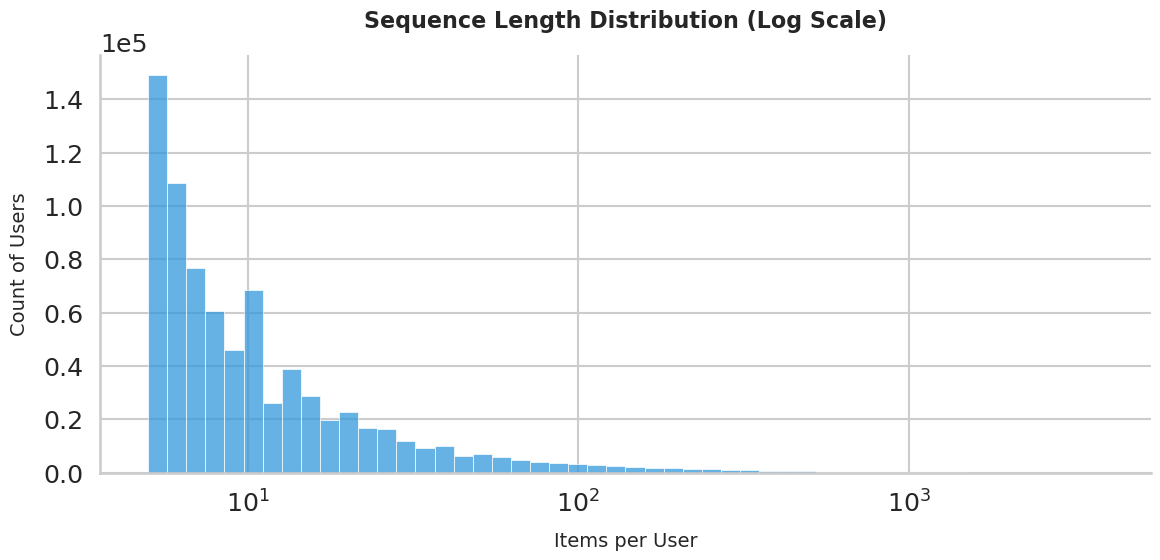

In [6]:
def plot_seq_lengths(lengths):
    if not lengths: return
    plt.figure(figsize=(12, 6))
    
    # Log scale is critical here
    sns.histplot(lengths, bins=50, log_scale=True, 
                 color='#3498db', edgecolor='white', linewidth=0.5)
    
    plt.title("Sequence Length Distribution (Log Scale)", pad=20)
    plt.xlabel("Items per User", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    
    # Sci notation for Y axis
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
plot_seq_lengths(seq_results['lengths'])

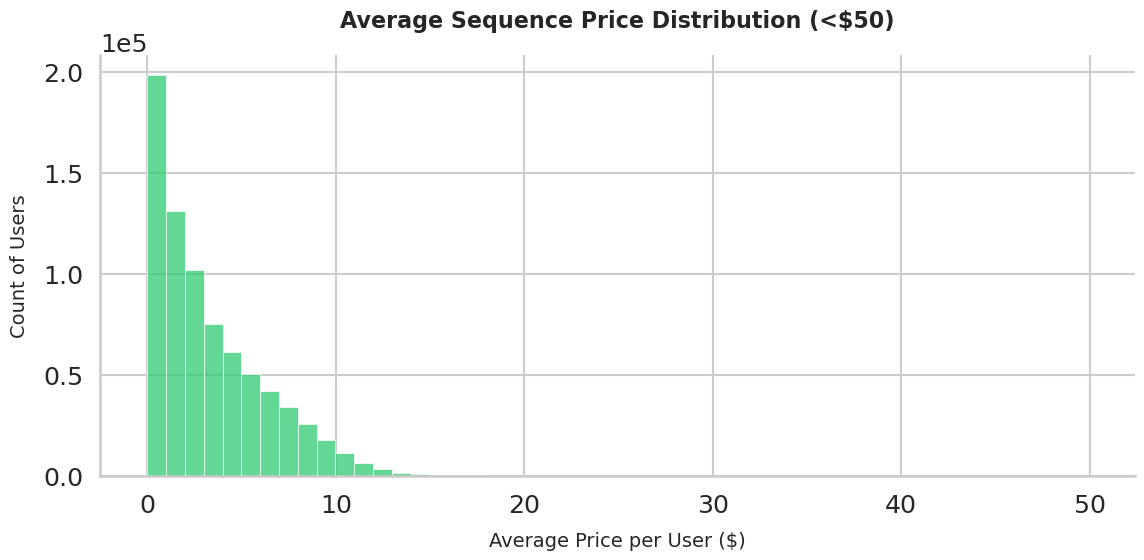

In [7]:
def plot_seq_prices(avg_prices):
    if not avg_prices: return
    # Cap at $50 for visibility
    vis_prices = [p for p in avg_prices if p <= 50]
    
    plt.figure(figsize=(12, 6))
    sns.histplot(vis_prices, bins=50, 
                 color='#2ecc71', edgecolor='white', linewidth=0.5)
    
    plt.title("Average Sequence Price Distribution (<$50)", pad=20)
    plt.xlabel("Average Price per User ($)", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_seq_prices(seq_results['avg_prices'])

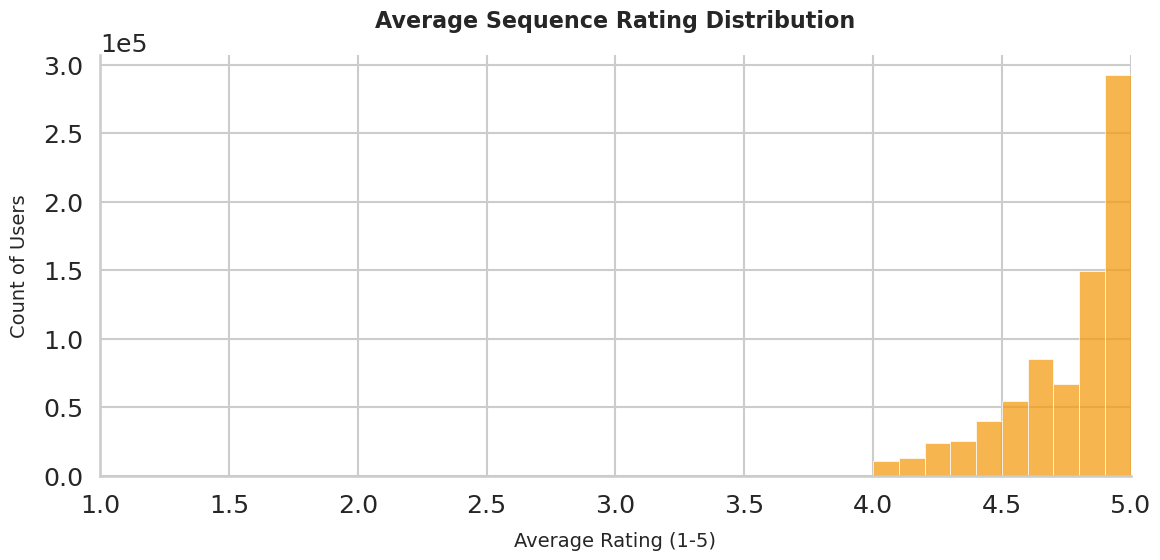

In [8]:
def plot_seq_ratings(avg_ratings):
    if not avg_ratings: return
    plt.figure(figsize=(12, 6))
    
    sns.histplot(avg_ratings, bins=10, 
                 color='#f39c12', edgecolor='white', linewidth=0.5)
    
    plt.title("Average Sequence Rating Distribution", pad=20)
    plt.xlabel("Average Rating (1-5)", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    plt.xlim(1, 5)
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_seq_ratings(seq_results['avg_ratings'])

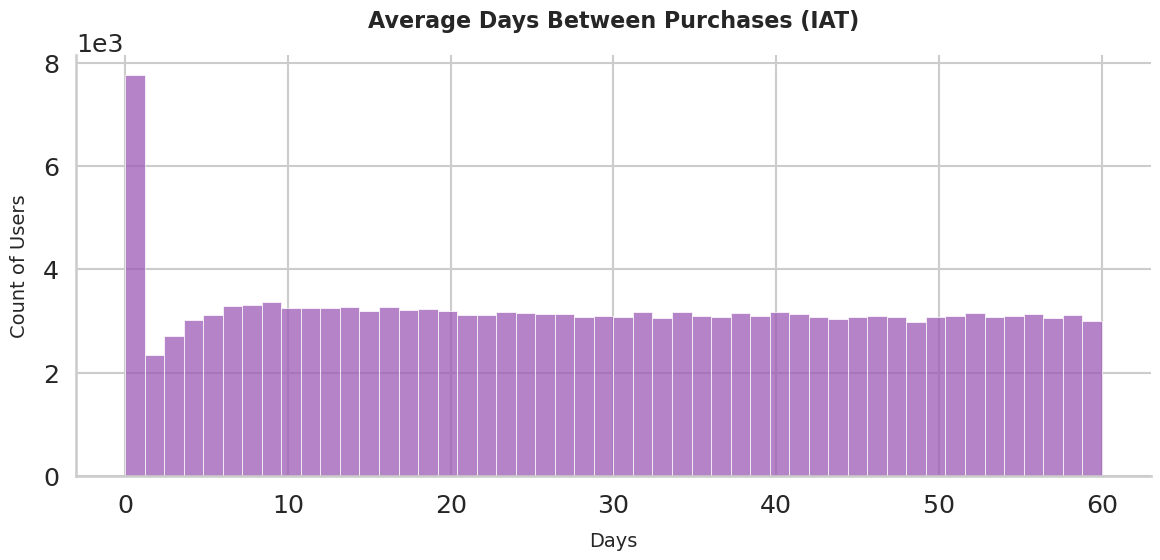

In [9]:
def plot_seq_iat(avg_iat_days):
    if not avg_iat_days: return
    # Cap at 60 days
    vis_iats = [t for t in avg_iat_days if t <= 60]
    
    plt.figure(figsize=(12, 6))
    sns.histplot(vis_iats, bins=50, 
                 color='#9b59b6', edgecolor='white', linewidth=0.5)
    
    plt.title("Average Days Between Purchases (IAT)", pad=20)
    plt.xlabel("Days", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_seq_iat(seq_results['avg_iat_days'])

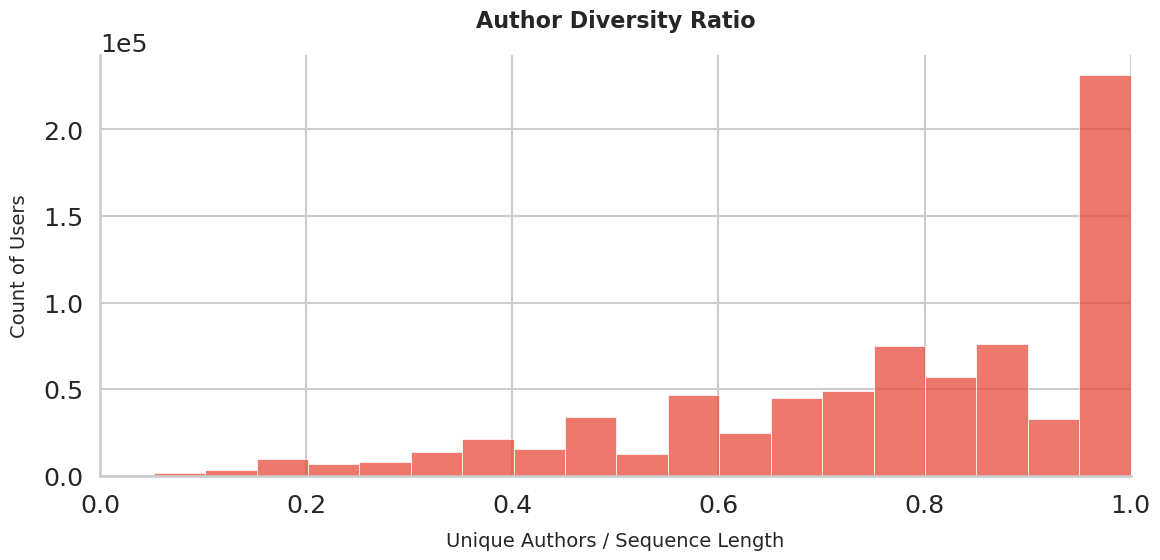

In [10]:
def plot_auth_diversity(author_diversity):
    if not author_diversity: return
    plt.figure(figsize=(12, 6))
    
    sns.histplot(author_diversity, bins=20, 
                 color='#e74c3c', edgecolor='white', linewidth=0.5)
    
    plt.title("Author Diversity Ratio", pad=20)
    plt.xlabel("Unique Authors / Sequence Length", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    plt.xlim(0, 1)
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_auth_diversity(seq_results['author_diversity'])

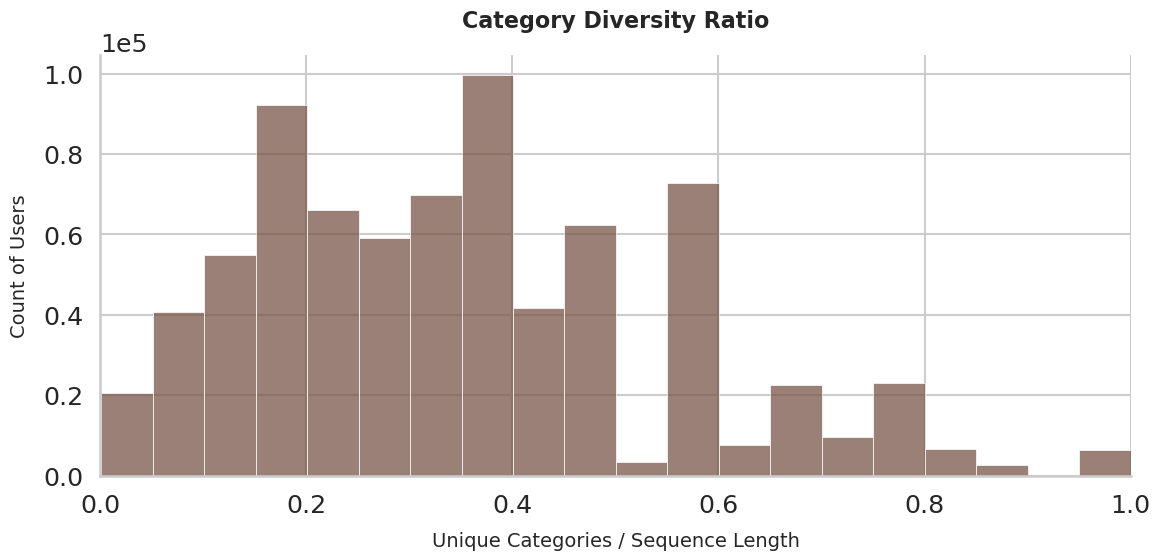

In [11]:
def plot_cat_diversity(cat_diversity):
    if not cat_diversity: return
    plt.figure(figsize=(12, 6))
    
    sns.histplot(cat_diversity, bins=20, 
                 color='#795548', edgecolor='white', linewidth=0.5)
    
    plt.title("Category Diversity Ratio", pad=20)
    plt.xlabel("Unique Categories / Sequence Length", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    plt.xlim(0, 1)
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_cat_diversity(seq_results['cat_diversity'])

In [12]:
import gzip
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# 1. Standard text-based tqdm
from tqdm import tqdm 

# --- Global Presentation Settings ---
def set_presentation_style():
    sns.set_context("talk", font_scale=1.1)
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 14

set_presentation_style()

# --- Processing Function ---
def process_advanced_sequences(seq_file, meta_file, top_k=15):
    print("Step 1: Indexing Metadata & Finding Top Genres...")
    
    meta_lookup = {}
    category_counter = Counter()
    
    # Pass 1: Load Metadata to find Top K Genres
    try:
        with gzip.open(meta_file, 'rb') as f:
            for line in tqdm(f, desc="Loading Metadata", unit=" items"):
                try:
                    data = json.loads(line.decode('utf-8').strip())
                    asin = data.get('parent_asin')
                    if not asin: continue
                    
                    # Author
                    author = "UNK"
                    a_obj = data.get('author')
                    if isinstance(a_obj, dict): author = a_obj.get('name', 'UNK')
                    elif isinstance(a_obj, str): author = a_obj
                    
                    # Category
                    cat = "Other"
                    cats = data.get('categories', [])
                    if isinstance(cats, list) and len(cats) > 0:
                        if len(cats) >= 3: cat = cats[2]
                        else: cat = cats[-1]
                    
                    meta_lookup[asin] = {'a': author, 'c': cat}
                    category_counter[cat] += 1
                except: continue
    except FileNotFoundError:
        print(f"Error: {meta_file} not found.")
        return None

    # Identify Top K Genres
    most_common = category_counter.most_common(top_k)
    top_genres = [x[0] for x in most_common]
    valid_genres_set = set(top_genres)
    
    print(f"Top {top_k} Genres identified: {top_genres[:5]}...")

    # --- Step 2: Calculate Metrics ---
    print("\nStep 2: Calculating Advanced Sequence Metrics...")
    
    repetition_scores = [] 
    drift_scores = []      
    
    # Init Transition Matrix
    matrix_keys = top_genres + ["Other"]
    # Dictionary of dictionaries to count transitions
    trans_counts = {k: {k2: 0 for k2 in matrix_keys} for k in matrix_keys}
    
    users_processed = 0
    
    try:
        with gzip.open(seq_file, 'rb') as f:
            for line in tqdm(f, desc="Processing Sequences", unit=" seqs"):
                try:
                    user_obj = json.loads(line.decode('utf-8').strip())
                    seq = user_obj.get('sequence', [])
                    if len(seq) < 2: continue 
                    
                    users_processed += 1
                    
                    # Map Attributes
                    seq_authors = []
                    seq_cats = []
                    
                    for item in seq:
                        meta = meta_lookup.get(item['asin'])
                        if meta:
                            seq_authors.append(meta['a'])
                            c_raw = meta['c']
                            c_mapped = c_raw if c_raw in valid_genres_set else "Other"
                            seq_cats.append(c_mapped)
                        else:
                            seq_authors.append("UNK")
                            seq_cats.append("Other")

                    # A. Author Repetition
                    repeats = 0
                    possible_repeats = len(seq_authors) - 1
                    for i in range(1, len(seq_authors)):
                        if seq_authors[i] == seq_authors[i-1] and seq_authors[i] != "UNK":
                            repeats += 1
                    repetition_scores.append(repeats / possible_repeats)

                    # B. Preference Drift
                    midpoint = len(seq_cats) // 2
                    first_half = set(seq_cats[:midpoint])
                    second_half = set(seq_cats[midpoint:])
                    
                    if not first_half or not second_half:
                        drift_scores.append(0.0)
                    else:
                        intersection = len(first_half.intersection(second_half))
                        union = len(first_half.union(second_half))
                        drift_scores.append(intersection / union)

                    # C. Transition Counts
                    for i in range(len(seq_cats) - 1):
                        src = seq_cats[i]
                        tgt = seq_cats[i+1]
                        trans_counts[src][tgt] += 1
                        
                except: continue
    except FileNotFoundError:
        print(f"Error: {seq_file} not found.")
        return None

    print(f"Done. Analyzed {users_processed:,} sequences.")
    
    # Convert Transition Dict to DataFrame and Normalize
    df_trans = pd.DataFrame(trans_counts).T
    df_norm = df_trans.div(df_trans.sum(axis=1), axis=0).fillna(0)

    return {
        "repetition_scores": repetition_scores,
        "drift_scores": drift_scores,
        "transition_matrix": df_norm # Normalized DataFrame
    }

# --- Execution ---
# Replace with your actual path variables
adv_results = process_advanced_sequences(DATA_PATH + FILE_SEQEUNCES, DATA_PATH + FILE_METADATA)

Step 1: Indexing Metadata & Finding Top Genres...


Loading Metadata: 1591371 items [01:17, 20539.23 items/s]


Top 15 Genres identified: ['Literature & Fiction', 'Romance', 'Religion & Spirituality', 'Science Fiction & Fantasy', "Children's eBooks"]...

Step 2: Calculating Advanced Sequence Metrics...


Processing Sequences: 761756 seqs [00:36, 20913.56 seqs/s]

Done. Analyzed 761,756 sequences.


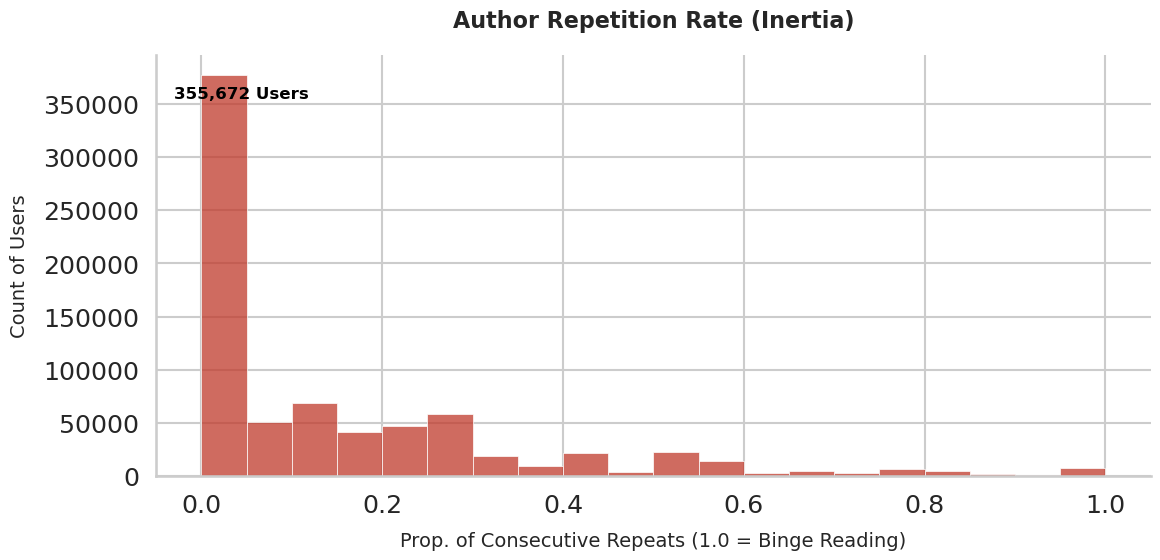

In [13]:
def plot_repetition_beautiful(repetition_scores):
    if not repetition_scores: return
    
    plt.figure(figsize=(12, 6))
    
    # Crimson/Red palette for "Alert/Inertia"
    sns.histplot(repetition_scores, bins=20, 
                 color='#c0392b', edgecolor='white', linewidth=0.5)
    
    plt.title("Author Repetition Rate (Inertia)", pad=20)
    plt.xlabel("Prop. of Consecutive Repeats (1.0 = Binge Reading)", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    
    # Add annotation for the zero bar
    zero_count = sum(1 for x in repetition_scores if x == 0)
    plt.text(-0.03, zero_count, f"{zero_count:,} Users", 
             fontsize=12, color='#000000', fontweight='bold')
    
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_repetition_beautiful(adv_results['repetition_scores'])

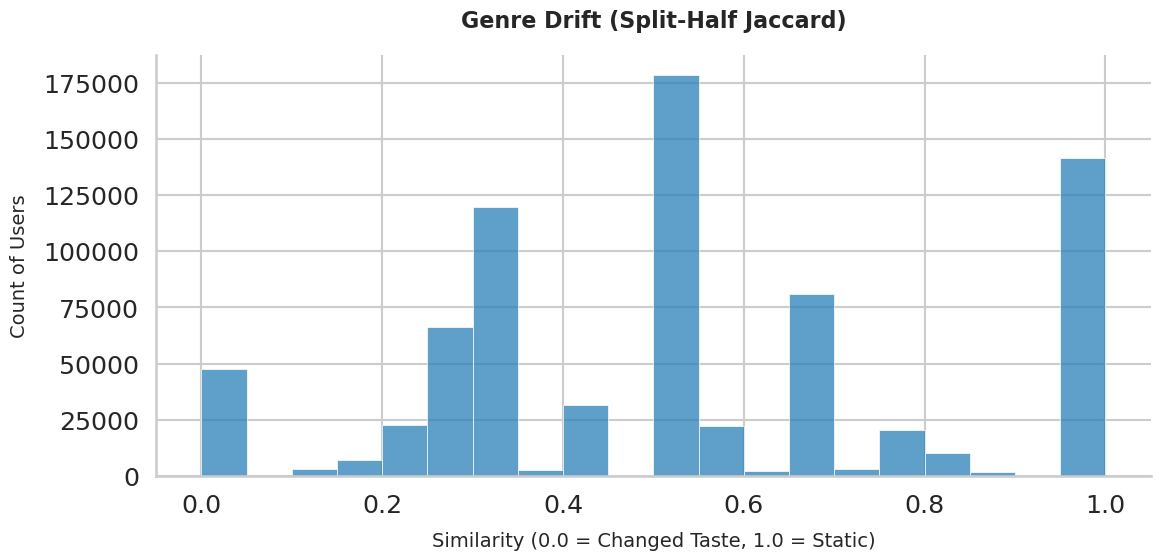

In [14]:
def plot_drift_beautiful(drift_scores):
    if not drift_scores: return
    
    plt.figure(figsize=(12, 6))
    
    # Royal Blue for "Stability"
    sns.histplot(drift_scores, bins=20, 
                 color='#2980b9', edgecolor='white', linewidth=0.5)
    
    plt.title("Genre Drift (Split-Half Jaccard)", pad=20)
    plt.xlabel("Similarity (0.0 = Changed Taste, 1.0 = Static)", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_drift_beautiful(adv_results['drift_scores'])

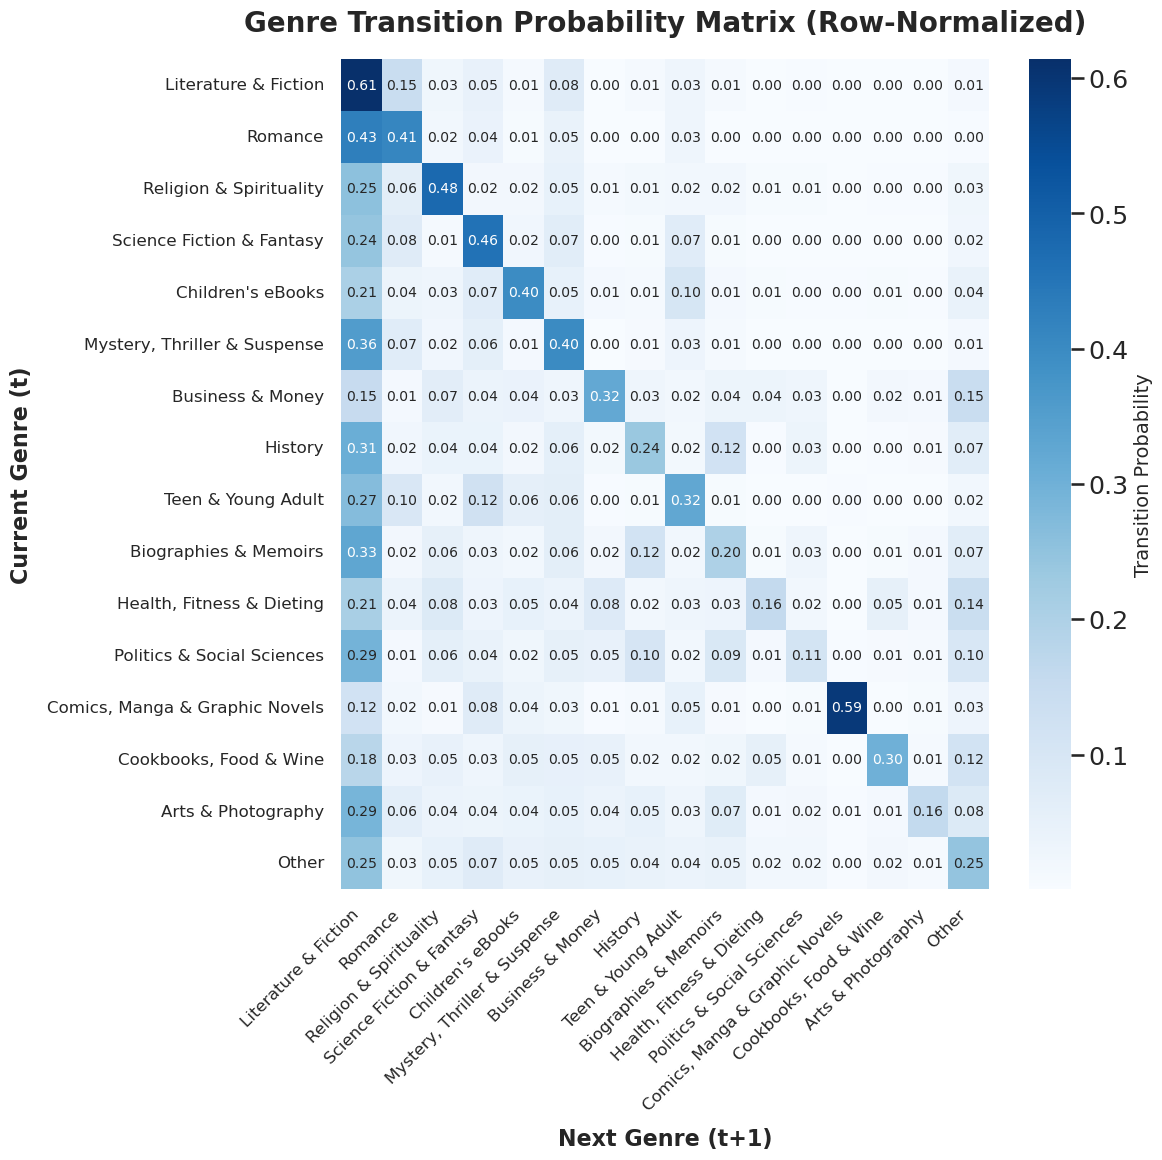

In [19]:
def plot_heatmap_beautiful(transition_matrix):
    if transition_matrix is None or transition_matrix.empty: return
    
    # Increase figure size slightly to accommodate text
    plt.figure(figsize=(12, 12))
    
    # --- 1. Control Annotation Font Size (Numbers inside cells) ---
    # annot_kws={'size': 11} sets the inner font size
    ax = sns.heatmap(transition_matrix, annot=True, fmt=".2f", 
                     cmap="Blues", cbar_kws={'label': 'Transition Probability'},
                     annot_kws={'size': 10}) # <--- CHANGE HERE
    
    # --- 2. Control Title and Axis Label Sizes ---
    ax.set_title("Genre Transition Probability Matrix (Row-Normalized)", 
                 pad=20, fontsize=20, fontweight='bold') # <--- CHANGE HERE
    
    ax.set_xlabel("Next Genre (t+1)", labelpad=10, fontsize=16, fontweight='bold') # <--- CHANGE HERE
    ax.set_ylabel("Current Genre (t)", labelpad=10, fontsize=16, fontweight='bold') # <--- CHANGE HERE
    
    # --- 3. Control Tick Label Sizes (Genre Names) ---
    # rotation=45 helps long genre names fit better
    plt.xticks(rotation=45, ha='right', fontsize=12) # <--- CHANGE HERE
    plt.yticks(rotation=0, fontsize=12)              # <--- CHANGE HERE
    
    # Adjust layout to make sure rotated labels don't get cut off
    plt.tight_layout()
    plt.show()

plot_heatmap_beautiful(adv_results['transition_matrix'])

In [1]:
import gzip
import json
from pprint import pprint # Used for clean dictionary printing

# 1. Define the files to process
DATA_PATH = '/data/sukhanna/cse258/'
FILE_REVIEWS = "Kindle_Store.jsonl.gz"
FILE_METADATA = "meta_Kindle_Store.jsonl.gz"

def read_and_print_first_entry(filepath: str):
    """
    Opens a .jsonl.gz file in binary mode, reads and decodes the first line, 
    and parses it as a JSON object (dictionary).
    """
    print("-" * 60)
    print(f"Reading first entry from: {filepath}")
    
    try:
        # Use 'rb' (read binary) mode for compressed files
        with gzip.open(filepath, 'rb') as f:
            # Read the first line of the file (returns bytes)
            first_line_bytes = f.readline()
            
            if not first_line_bytes:
                print("Error: File is empty or cannot be read.")
                return

            # Decode the bytes to a standard string (using UTF-8)
            first_line_str = first_line_bytes.decode('utf-8').strip()
            
            # Parse the JSON string into a Python dictionary
            entry_dict = json.loads(first_line_str)
            
            pprint(entry_dict)
    except FileNotFoundError:
        print(f"Error: File not found at path: {filepath}")
    except Exception as e:
        print(f"An error occurred while processing {filepath}: {e}")

# --- Execution ---
read_and_print_first_entry(DATA_PATH + FILE_REVIEWS)
read_and_print_first_entry(DATA_PATH + FILE_METADATA)

------------------------------------------------------------
Reading first entry from: /data/sukhanna/cse258/Kindle_Store.jsonl.gz
{'asin': 'B00LXRJICK',
 'helpful_vote': 0,
 'images': [],
 'parent_asin': 'B00LXRJICK',
 'rating': 5.0,
 'text': 'GRUMLEY is on par with Clive Cussler and his Dirk Pitt series of '
         'novels.  His stories are well written and imaginative and I cannot '
         'wait for the next one.',
 'timestamp': 1427541413000,
 'title': 'excellent writer reminds me of Clive Cussler',
 'user_id': 'AFKZENTNBQ7A7V7UXW5JJI6UGRYQ',
 'verified_purchase': False}
------------------------------------------------------------
Reading first entry from: /data/sukhanna/cse258/meta_Kindle_Store.jsonl.gz
{'author': {'about': ['A New York Times and USA Today Bestselling Author, '
                      'Penelope Sky is known for her dark romance that makes '
                      'you fall for her characters....no matter how dark they '
                      'seem. Her books are 

In [2]:
from typing import List, Optional

def get_entry_keys(filepath: str) -> Optional[List[str]]:
    """
    Opens a .jsonl.gz file, reads the first entry, and returns the list of its primary keys.
    Returns None if an error occurs or the file is empty.
    """
    try:
        # 'rb' mode for compressed files
        with gzip.open(filepath, 'rb') as f:
            first_line_bytes = f.readline()
            
            if not first_line_bytes:
                print(f"Warning: File {filepath} is empty.")
                return None
            
            # Decode to string and parse JSON
            first_line_str = first_line_bytes.decode('utf-8').strip()
            entry_dict = json.loads(first_line_str)
            
            return list(entry_dict.keys())
            
    except FileNotFoundError:
        print(f"Error: File not found at path: {filepath}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from the first line of {filepath}.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing {filepath}: {e}")
        return None

# --- Execution and Printing ---

print("## Fields in Review Data (Kindle_Store.jsonl.gz):")
review_keys = get_entry_keys(DATA_PATH + FILE_REVIEWS)
if review_keys:
    print(review_keys)

print("\n## Fields in Metadata (meta_Kindle_Store.jsonl.gz):")
meta_keys = get_entry_keys(DATA_PATH + FILE_METADATA)
if meta_keys:
    print(meta_keys)

## Fields in Review Data (Kindle_Store.jsonl.gz):
['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

## Fields in Metadata (meta_Kindle_Store.jsonl.gz):
['main_category', 'title', 'subtitle', 'author', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']


**Task 1** \
Round Up all the items and users into txt files

In [4]:
# Output filenames from the previous step
PATH_USERS = "unique_users.txt"
PATH_ITEMS_META = "unique_items_metadata.txt"
PATH_ITEMS_REV = "unique_items_reviewed.txt"

def analyze_intersections():
    print("Loading ID lists...")
    
    # Helper to load file to set
    def load_ids(filepath):
        with open(filepath, 'r') as f:
            return set(line.strip() for line in f)

    users = load_ids(DATA_PATH + PATH_USERS)
    items_meta = load_ids(DATA_PATH + PATH_ITEMS_META)
    items_reviewed = load_ids(DATA_PATH + PATH_ITEMS_REV)
    
    # --- Computations ---
    n_users = len(users)
    n_meta = len(items_meta)
    n_rev = len(items_reviewed)
    
    # Intersection: Items that appear in BOTH lists
    valid_items = items_reviewed.intersection(items_meta)
    
    # Difference: Items in Reviews but NOT in Metadata
    ghost_items = items_reviewed - items_meta
    
    # Coverage Calculation
    coverage = (len(valid_items) / n_meta) * 100 if n_meta > 0 else 0
    
    # --- Reporting ---
    print(f"--- Dimension Stats ---")
    print(f"Unique Users (Rows):           {n_users:,}")
    print(f"Total Catalog Size (Cols):     {n_meta:,}")
    print(f"Items with Reviews:            {n_rev:,}")
    
    print(f"\n--- Intersection Health ---")
    print(f"Valid Items (Have Meta + Rev): {len(valid_items):,}")
    print(f"Ghost Items (No Metadata):     {len(ghost_items):,} ({(len(ghost_items)/n_rev)*100:.2f}% of reviewed items)")
    print(f"Catalog Coverage:              {coverage:.2f}% of catalog has interactions")
    
    print(f"\n--- Matrix Scale ---")
    print(f"Theoretical Matrix Size:       {n_users * len(valid_items):,} elements")

analyze_intersections()

Loading ID lists...
--- Dimension Stats ---
Unique Users (Rows):           5,646,991
Total Catalog Size (Cols):     1,591,371
Items with Reviews:            1,590,697

--- Intersection Health ---
Valid Items (Have Meta + Rev): 1,590,697
Ghost Items (No Metadata):     0 (0.00% of reviewed items)
Catalog Coverage:              99.96% of catalog has interactions

--- Matrix Scale ---
Theoretical Matrix Size:       8,982,651,642,727 elements


**Review Data EDA**

In [6]:
import gzip
import json
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
# 1. Changed to standard text-based tqdm
from tqdm import tqdm 

# --- Global Presentation Settings ---
def set_presentation_style():
    """Sets high-quality plotting defaults for presentations."""
    sns.set_context("talk", font_scale=1.1)  # Bigger font for slides
    sns.set_style("whitegrid")               # Clean grid background
    plt.rcParams['figure.figsize'] = (12, 6) # Default 16:9 aspect ratio
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 14

set_presentation_style()

# --- Processing Function ---
def process_review_data(file_path):
    """
    Streams the file and aggregates statistics. 
    Returns raw data structures for plotting.
    """
    rating_counts = Counter()
    monthly_activity = Counter()
    year_rating_sum = defaultdict(float)
    year_rating_count = defaultdict(int)
    review_lengths = [] 
    
    print(f"Streaming {file_path}...")
    
    lines_read = 0
    valid_entries = 0
    
    try:
        with gzip.open(file_path, 'rb') as f:
            # 2. Standard tqdm (text widget)
            for line in tqdm(f, desc="Processing Rows", unit=" rows"):
                lines_read += 1
                try:
                    data = json.loads(line.decode('utf-8').strip())
                    
                    # --- Rating ---
                    rating = data.get('rating')
                    if rating is not None:
                        rating = float(rating)
                        rating_counts[rating] += 1
                        
                    # --- Temporal ---
                    ts_raw = data.get('timestamp')
                    if ts_raw:
                        # Handle Milliseconds
                        ts_val = float(ts_raw)
                        if ts_val > 100000000000:
                            ts_val = ts_val / 1000.0
                            
                        dt = datetime.datetime.fromtimestamp(ts_val)
                        month_key = dt.strftime('%Y-%m') 
                        year_key = dt.year
                        
                        monthly_activity[month_key] += 1
                        valid_entries += 1
                        
                        if rating is not None:
                            year_rating_sum[year_key] += rating
                            year_rating_count[year_key] += 1

                    # --- Text Length ---
                    text = data.get('text', "")
                    if text:
                        review_lengths.append(len(text.split()))
                        
                except (ValueError, KeyError, OverflowError):
                    continue
                    
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None

    print(f"Done. Processed {lines_read} lines. Found {valid_entries} valid entries.")
    
    return {
        "rating_counts": rating_counts,
        "monthly_activity": monthly_activity,
        "year_sums": year_rating_sum,
        "year_counts": year_rating_count,
        "review_lengths": review_lengths
    }

# --- Execution ---
# Replace 'DATA_PATH + FILE_REVIEWS' with your actual path variable
results = process_review_data(DATA_PATH + FILE_REVIEWS)

Streaming /data/sukhanna/cse258/Kindle_Store.jsonl.gz...


Processing Rows: 25577616 rows [07:11, 59307.05 rows/s]

Done. Processed 25577616 lines. Found 25577616 valid entries.


/tmp/ipykernel_2091520/2307948808.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(labels), y=list(values), palette="viridis")


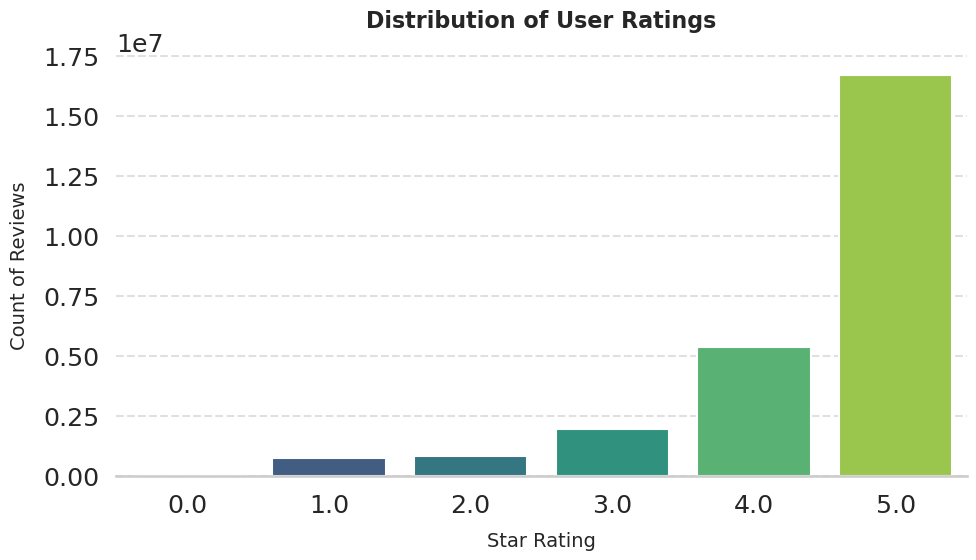

In [7]:
def plot_ratings_beautiful(rating_counts):
    # Data Prep
    sorted_ratings = sorted(rating_counts.items())
    if not sorted_ratings: return
    labels, values = zip(*sorted_ratings)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Using 'viridis' or 'magma' gives a premium look to ordinal data
    ax = sns.barplot(x=list(labels), y=list(values), palette="viridis")
    
    # Aesthetics
    ax.set_title("Distribution of User Ratings", pad=20)
    ax.set_xlabel("Star Rating", labelpad=10)
    ax.set_ylabel("Count of Reviews", labelpad=10)
    
    # Clean up borders
    sns.despine(left=True, bottom=False)
    
    # Add simple grid lines just on Y axis
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

plot_ratings_beautiful(results['rating_counts'])

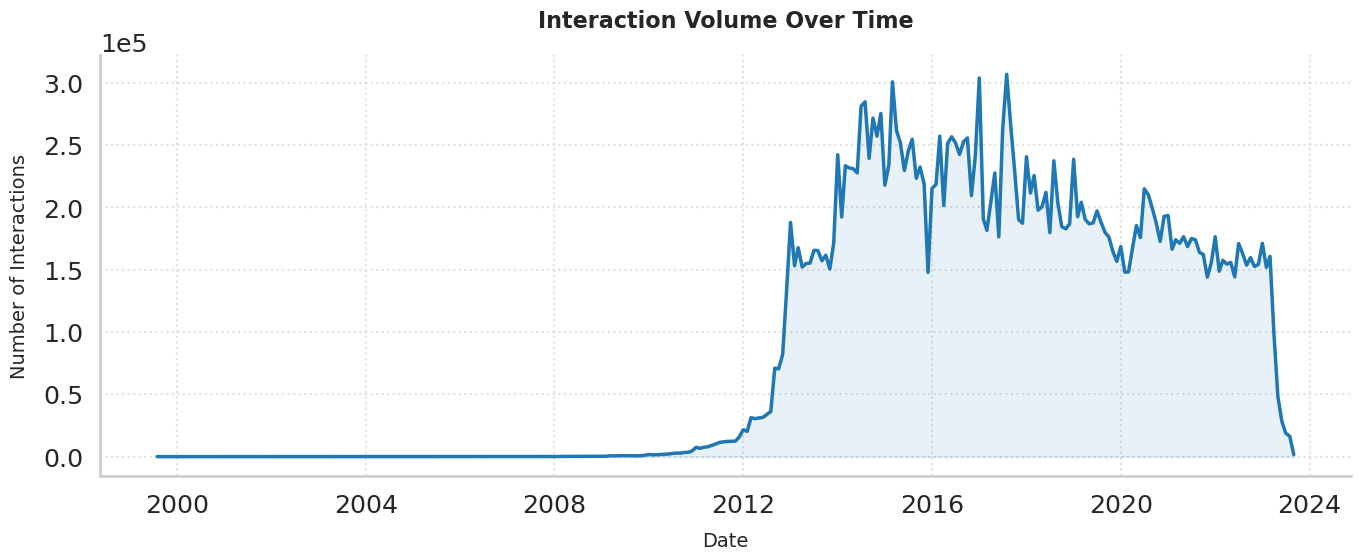

In [14]:
import matplotlib.ticker as ticker

def plot_timeline_beautiful(monthly_activity):
    # Data Prep
    sorted_months = sorted(monthly_activity.items())
    if not sorted_months: return
    dates_str, volumes = zip(*sorted_months)
    date_objs = [datetime.datetime.strptime(d, '%Y-%m') for d in dates_str]
    
    # Plotting
    plt.figure(figsize=(14, 6))
    
    # Solid distinct color line
    plt.plot(date_objs, volumes, color='#1f77b4', linewidth=2.5)
    plt.fill_between(date_objs, volumes, color='#1f77b4', alpha=0.1)
    
    # Aesthetics
    plt.title("Interaction Volume Over Time", pad=20)
    plt.xlabel("Date", labelpad=10)
    plt.ylabel("Number of Interactions", labelpad=10)
    
    # --- Scientific Notation Config ---
    ax = plt.gca() # Get Current Axis
    # style='sci' forces scientific notation
    # scilimits=(0,0) ensures it triggers even for smaller numbers (like 10^3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    # Remove top/right spines
    sns.despine()
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

plot_timeline_beautiful(results['monthly_activity'])

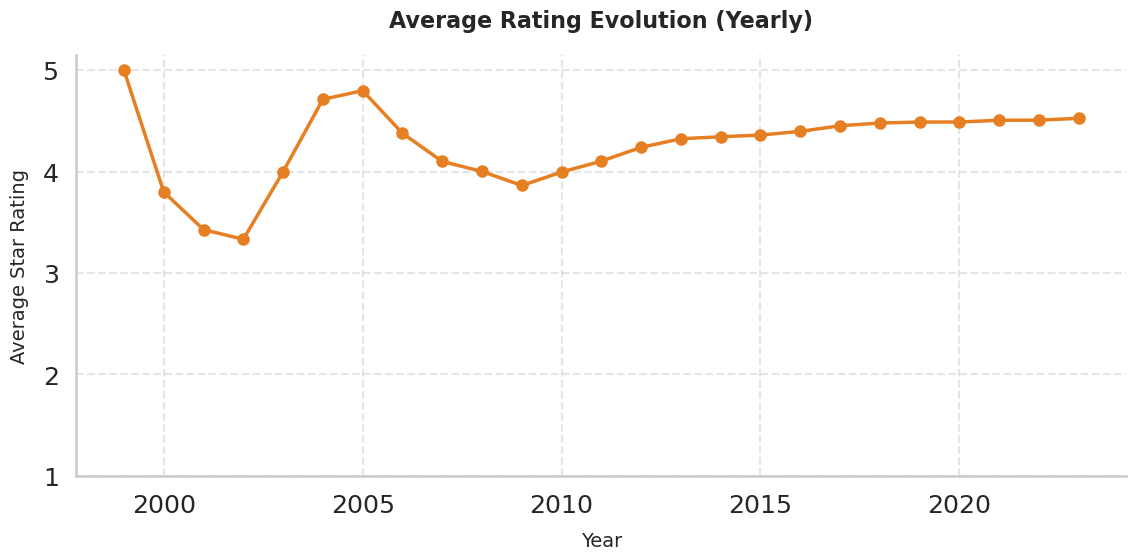

In [12]:
def plot_evolution_beautiful(year_sums, year_counts):
    # Data Prep
    years = sorted(year_counts.keys())
    if not years: return
    avg_ratings = [year_sums[y]/year_counts[y] for y in years]
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Line plot with markers to highlight specific years
    plt.plot(years, avg_ratings, marker='o', markersize=8, 
             color='#e67e22', linewidth=2.5, linestyle='-')
    
    # Aesthetics
    plt.title("Average Rating Evolution (Yearly)", pad=20)
    plt.xlabel("Year", labelpad=10)
    plt.ylabel("Average Star Rating", labelpad=10)
    plt.ylim(1, 5.15) # Fix Y-axis to logical bounds
    
    sns.despine()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

plot_evolution_beautiful(results['year_sums'], results['year_counts'])

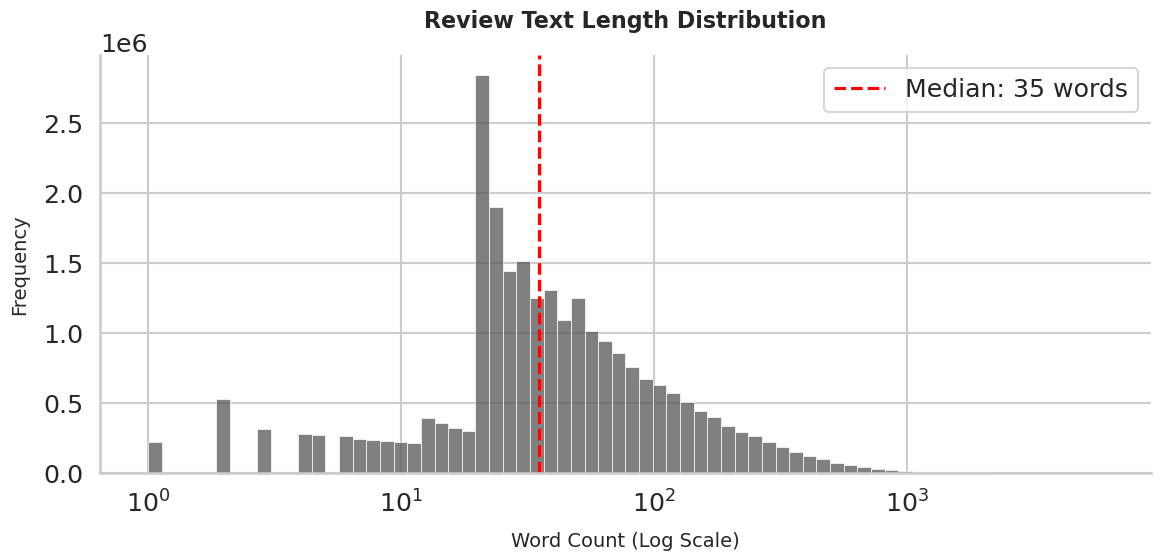

In [13]:
def plot_lengths_beautiful(review_lengths):
    if not review_lengths: return
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Histogram with log scale
    # Using a neutral gray color allows the shape to stand out
    sns.histplot(review_lengths, bins=70, log_scale=True, 
                 color="#555555", edgecolor="white", linewidth=0.5)
    
    # Aesthetics
    plt.title("Review Text Length Distribution", pad=20)
    plt.xlabel("Word Count (Log Scale)", labelpad=10)
    plt.ylabel("Frequency", labelpad=10)
    
    # Add a vertical line for the median
    median_len = np.median(review_lengths)
    plt.axvline(median_len, color='red', linestyle='--', label=f'Median: {int(median_len)} words')
    plt.legend()
    
    sns.despine()
    
    plt.tight_layout()
    plt.show()

plot_lengths_beautiful(results['review_lengths'])

**Metadata EDA**

In [21]:
import gzip
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# 1. Standard text-based tqdm
from tqdm import tqdm 

# --- Global Presentation Settings ---
def set_presentation_style():
    """Sets high-quality plotting defaults for presentations."""
    sns.set_context("talk", font_scale=1.1)
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 14

set_presentation_style()

# --- Helper ---
def parse_price_refactored(price_obj):
    if price_obj is None: return None
    if isinstance(price_obj, (float, int)): return float(price_obj)
    if isinstance(price_obj, str):
        clean = re.sub(r'[$,\s]', '', price_obj)
        try: return float(clean)
        except ValueError: return None
    return None

# --- Processing Function ---
def process_metadata(file_path):
    """
    Streams the file and aggregates statistics.
    Returns dictionary of raw data for plotting.
    """
    print(f"Streaming {file_path}...")
    
    category_counts = Counter()
    author_counts = Counter()
    prices = []
    desc_lengths = []
    
    total_items = 0
    has_description = 0
    
    try:
        with gzip.open(file_path, 'rb') as f:
            for line in tqdm(f, desc="Processing Items", unit=" items"):
                try:
                    data = json.loads(line.decode('utf-8').strip())
                    total_items += 1
                    
                    # --- 1. Taxonomy ---
                    cats = data.get('categories', [])
                    if isinstance(cats, list) and len(cats) > 0:
                        # Logic to find "Main" category (usually index 2)
                        if len(cats) >= 3: main_cat = cats[2]
                        else: main_cat = cats[-1]
                        
                        if main_cat not in ['Kindle Store', 'Kindle eBooks']:
                            category_counts[main_cat] += 1
                    
                    # --- 2. Author ---
                    auth_obj = data.get('author')
                    author_name = None
                    if isinstance(auth_obj, dict): author_name = auth_obj.get('name')
                    elif isinstance(auth_obj, str): author_name = auth_obj
                        
                    if author_name and author_name.lower() not in ['unknown', '']:
                        author_counts[author_name] += 1

                    # --- 3. Price ---
                    p_val = parse_price_refactored(data.get('price'))
                    if p_val is not None:
                        prices.append(p_val)
                            
                    # --- 4. Description ---
                    desc = data.get('description')
                    final_desc = ""
                    if isinstance(desc, list): final_desc = " ".join(desc)
                    elif isinstance(desc, str): final_desc = desc
                        
                    if final_desc.strip():
                        has_description += 1
                        desc_lengths.append(len(final_desc.split()))
                        
                except (json.JSONDecodeError, KeyError, AttributeError):
                    continue
                    
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None

    print(f"Done. Processed {total_items:,} items.")
    print(f"Price Coverage: {(len(prices)/total_items)*100:.1f}%")
    print(f"Description Coverage: {(has_description/total_items)*100:.1f}%")

    return {
        "category_counts": category_counts,
        "author_counts": author_counts,
        "prices": prices,
        "desc_lengths": desc_lengths
    }

# --- Execution ---
# Replace with your actual path variable
meta_results = process_metadata(DATA_PATH + FILE_METADATA)

Streaming /data/sukhanna/cse258/meta_Kindle_Store.jsonl.gz...


Processing Items: 1591371 items [01:48, 14700.53 items/s]

Done. Processed 1,591,371 items.
Price Coverage: 85.4%
Description Coverage: 40.2%


/tmp/ipykernel_2091520/694447089.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(cat_vals), y=list(cat_names), palette="mako")


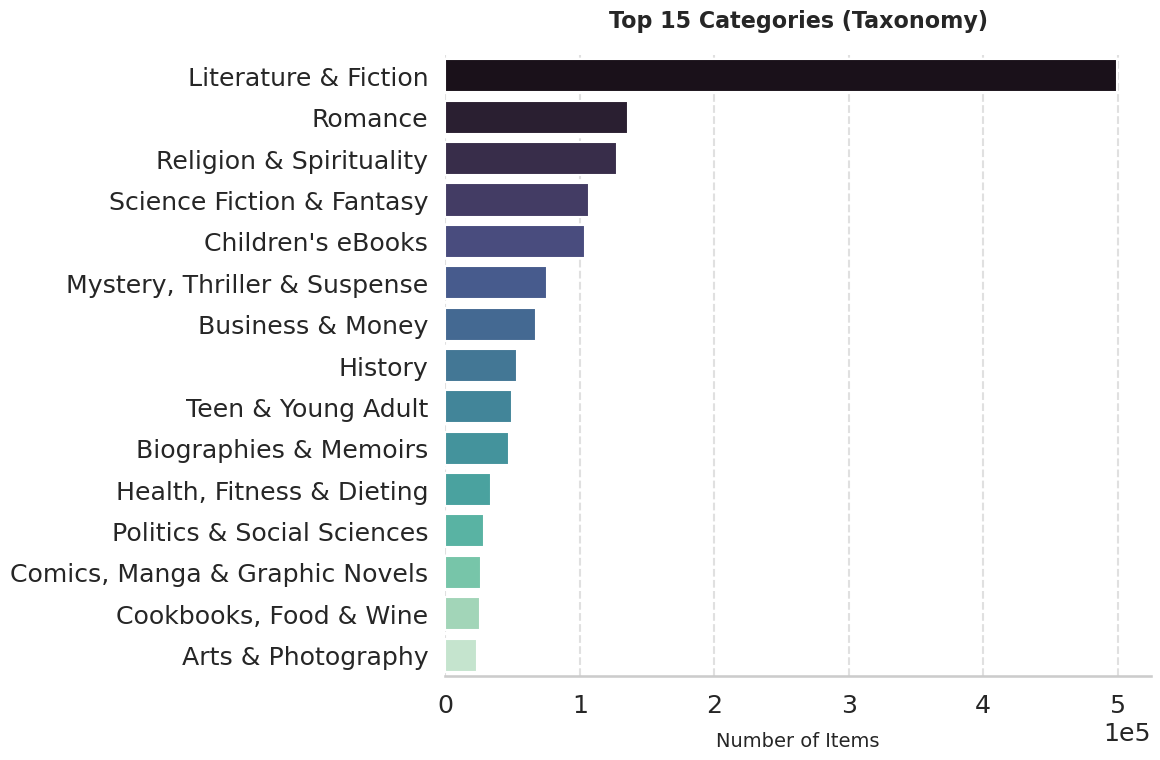

In [22]:
def plot_categories_beautiful(category_counts):
    # Data Prep
    top_cats = category_counts.most_common(15)
    if not top_cats: return
    cat_names, cat_vals = zip(*top_cats)
    
    # Plotting
    plt.figure(figsize=(12, 8)) # Taller for horizontal bars
    
    # 'mako' is a professional blue-green palette
    ax = sns.barplot(x=list(cat_vals), y=list(cat_names), palette="mako")
    
    # Aesthetics
    ax.set_title("Top 15 Categories (Taxonomy)", pad=20)
    ax.set_xlabel("Number of Items", labelpad=10)
    ax.set_ylabel("") # Categories are self-explanatory
    
    # Scientific notation for X-axis if numbers are huge
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    
    sns.despine(left=True, bottom=False)
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

plot_categories_beautiful(meta_results['category_counts'])

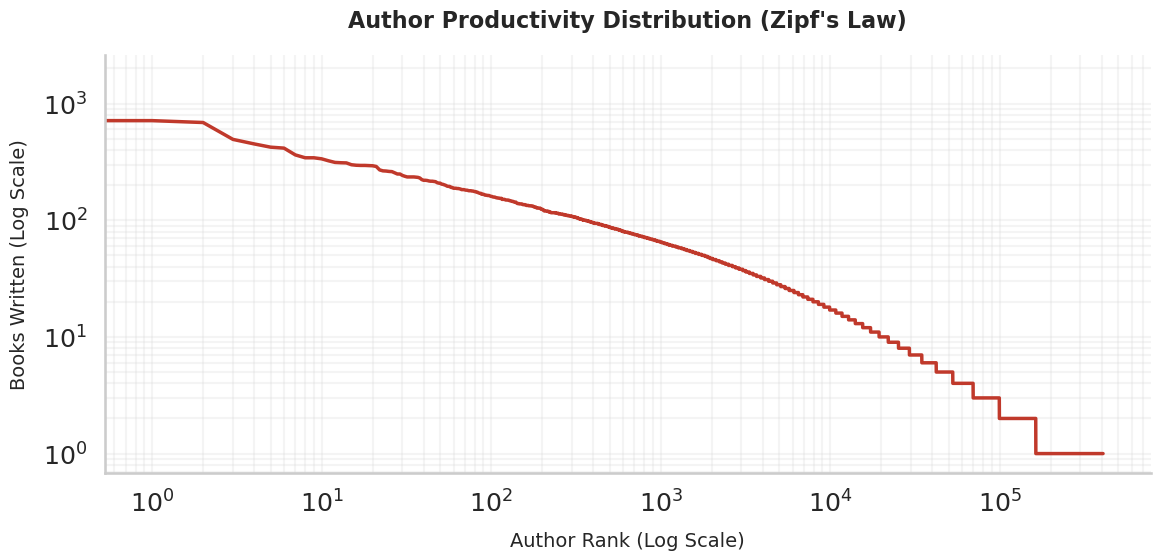

In [23]:
def plot_authors_beautiful(author_counts):
    # Data Prep
    author_vals = sorted(list(author_counts.values()), reverse=True)
    if not author_vals: return
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Thick line for visibility
    plt.loglog(author_vals, color='#c0392b', linewidth=2.5)
    
    # Aesthetics
    plt.title("Author Productivity Distribution (Zipf's Law)", pad=20)
    plt.xlabel("Author Rank (Log Scale)", labelpad=10)
    plt.ylabel("Books Written (Log Scale)", labelpad=10)
    
    sns.despine()
    # Log plots need specific grid settings
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()

plot_authors_beautiful(meta_results['author_counts'])

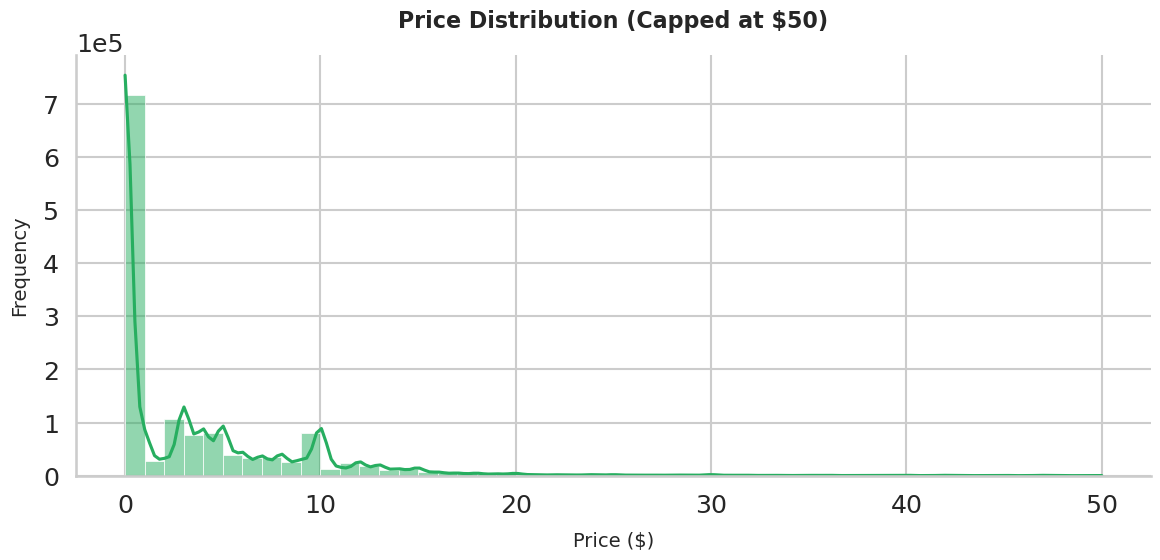

In [24]:
def plot_prices_beautiful(prices):
    if not prices: return
    
    # Filter outliers for the plot (keep focus on 99% of data)
    filtered_prices = [p for p in prices if p <= 50]
    
    plt.figure(figsize=(12, 6))
    
    # Hist with KDE
    sns.histplot(filtered_prices, bins=50, kde=True, 
                 color='#27ae60', edgecolor='white', linewidth=0.5)
    
    # Aesthetics
    plt.title("Price Distribution (Capped at $50)", pad=20)
    plt.xlabel("Price ($)", labelpad=10)
    plt.ylabel("Frequency", labelpad=10)
    
    # Scientific notation for Y-axis (counts)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    sns.despine()
    
    plt.tight_layout()
    plt.show()

plot_prices_beautiful(meta_results['prices'])

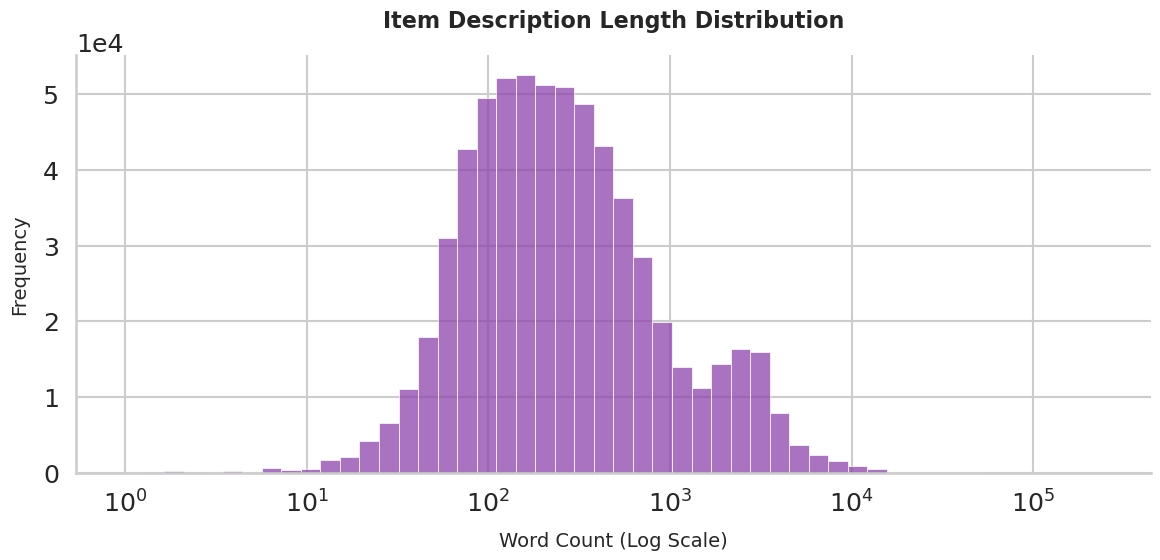

In [25]:
def plot_descriptions_beautiful(desc_lengths):
    if not desc_lengths: return
    
    plt.figure(figsize=(12, 6))
    
    # Log scale histogram
    sns.histplot(desc_lengths, bins=50, log_scale=True, 
                 color='#8e44ad', edgecolor='white', linewidth=0.5)
    
    # Aesthetics
    plt.title("Item Description Length Distribution", pad=20)
    plt.xlabel("Word Count (Log Scale)", labelpad=10)
    plt.ylabel("Frequency", labelpad=10)
    
    # Scientific notation for Y-axis
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    sns.despine()
    
    plt.tight_layout()
    plt.show()

plot_descriptions_beautiful(meta_results['desc_lengths'])

In [1]:
import pickle
import pandas as pd

In [2]:
train_data = pd.read_pickle('/data/sukhanna/cse258/processed_100/train_data.pkl')
val_data = pd.read_pickle('/data/sukhanna/cse258/processed_100/val_data.pkl')
test_data = pd.read_pickle('/data/sukhanna/cse258/processed_100/test_data.pkl')

id2item = pd.read_pickle('/data/sukhanna/cse258/processed_100/id2item.pkl')
item2id = pd.read_pickle('/data/sukhanna/cse258/processed_100/item2id.pkl')

id2user = pd.read_pickle('/data/sukhanna/cse258/processed_100/id2user.pkl')
user2id = pd.read_pickle('/data/sukhanna/cse258/processed_100/user2id.pkl')


In [3]:
train_data[8551]

{'sequence': [{'item_id': 239726, 'timestamp': 1373155244.0, 'rating': 4.0},
  {'item_id': 100927, 'timestamp': 1398238497.0, 'rating': 5.0},
  {'item_id': 239727, 'timestamp': 1447851667.0, 'rating': 5.0}],
 'is_autoregressive': True}

In [4]:
val_data[8551]

{'sequence': [{'item_id': 239726, 'timestamp': 1373155244.0, 'rating': 4.0},
  {'item_id': 100927, 'timestamp': 1398238497.0, 'rating': 5.0},
  {'item_id': 239727, 'timestamp': 1447851667.0, 'rating': 5.0}],
 'target': {'item_id': 239728, 'timestamp': 1448406034.0, 'rating': 4.0},
 'is_autoregressive': False}

In [5]:
test_data[8551]

{'sequence': [{'item_id': 239726, 'timestamp': 1373155244.0, 'rating': 4.0},
  {'item_id': 100927, 'timestamp': 1398238497.0, 'rating': 5.0},
  {'item_id': 239727, 'timestamp': 1447851667.0, 'rating': 5.0},
  {'item_id': 239728, 'timestamp': 1448406034.0, 'rating': 4.0}],
 'target': {'item_id': 135537, 'timestamp': 1569107616.096, 'rating': 4.0},
 'is_autoregressive': False}

# BPR

In [ ]:
import torch
from torch.utils.data import Dataset
import random
import numpy as np

class BPRDataset(Dataset):
    def __init__(self, train_data, val_data, test_data, num_items):
        """
        Args:
            train_data: List of dicts containing 'sequence' (list of dicts with 'item_id').
            val_data: List of dicts containing 'target' ('item_id').
            test_data: List of dicts containing 'target' ('item_id').
            num_items: Total count of items in catalog (e.g., 349,000).
                       Assumes IDs range from 1 to num_items.
        """
        self.num_items = num_items
        
        # Pre-process data into simple sets for O(1) lookups
        self.user_history = []
        self.exclusion_sets = []
        self.valid_user_indices = []

        # Assuming train_data, val_data, test_data are aligned by list index (User ID)
        for u_idx in range(len(train_data)):
            # 1. Extract Train Sequence
            # The data structure is nested: entry['sequence'] -> list of dicts -> 'item_id'
            train_seq = [x['item_id'] for x in train_data[u_idx]['sequence']]
            
            # 2. Extract Validation and Test Targets
            val_target = val_data[u_idx]['target']['item_id']
            test_target = test_data[u_idx]['target']['item_id']
            
            # 3. Store Positive History for Training (only train_seq matters for BPR positive sampling)
            # We filter out users with empty sequences to prevent errors
            if len(train_seq) > 0:
                self.user_history.append(train_seq)
                
                # 4. Build Exclusion Set (Train + Val + Test)
                # These are items we CANNOT use as negatives
                exclude = set(train_seq)
                exclude.add(val_target)
                exclude.add(test_target)
                self.exclusion_sets.append(exclude)
                
                # Keep track of original user index if needed, though BPR usually learns 
                # user_id based on the row index of this dataset
                self.valid_user_indices.append(u_idx)

    def __len__(self):
        return len(self.user_history)

    def __getitem__(self, idx):
        """
        Returns:
            user_id: (0 to N-1)
            pos_item: (0 to M-1)
            neg_item: (0 to M-1)
        """
        # 1. User ID (mapped to 0-index)
        # We use the index of the dataset as the user_id for embedding lookup
        user_id = idx 
        
        # 2. Positive Sampling
        # Randomly select one item from the user's training history
        pos_id_raw = random.choice(self.user_history[idx])
        
        # 3. Negative Sampling with Exclusion
        # Randomly sample until we find an item NOT in the exclusion set
        while True:
            # Sample from 1 to num_items (inclusive)
            neg_id_raw = random.randint(1, self.num_items)
            
            if neg_id_raw not in self.exclusion_sets[idx]:
                break
        
        # 4. Convert to 0-based indexing for PyTorch Embedding Layers
        # Input IDs are 1-based, so we subtract 1.
        return (
            torch.tensor(user_id, dtype=torch.long),
            torch.tensor(pos_id_raw - 1, dtype=torch.long),
            torch.tensor(neg_id_raw - 1, dtype=torch.long)
        )

# class BPRDataset(Dataset):
#     def __init__(self, train_data, val_data, test_data, num_items, n_neg=1): # <--- Added n_neg
#         # ... (previous init code is same) ...
#         self.n_neg = n_neg # Store it

#     def __getitem__(self, idx):
#         user_id = idx 
#         pos_id_raw = random.choice(self.user_history[idx])
        
#         # --- MODIFIED BLOCK START ---
#         neg_samples = []
#         for _ in range(self.n_neg): # Loop N times
#             while True:
#                 neg_id_raw = random.randint(1, self.num_items)
#                 if neg_id_raw not in self.exclusion_sets[idx]:
#                     neg_samples.append(neg_id_raw - 1)
#                     break
#         # --- MODIFIED BLOCK END ---

#         return (
#             torch.tensor(user_id, dtype=torch.long),
#             torch.tensor(pos_id_raw - 1, dtype=torch.long),
#             torch.tensor(neg_samples, dtype=torch.long) # Shape: [n_neg]
#         )

In [ ]:
import torch
import torch.nn as nn

class BPRMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        """
        Args:
            num_users: Total number of unique users.
            num_items: Total number of unique items.
            embedding_dim: Size of the latent vectors (e.g., 32, 64, 128).
        """
        super(BPRMF, self).__init__()
        
        # 1. User Embeddings
        # Shape: [num_users, embedding_dim]
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        
        # 2. Item Embeddings
        # Shape: [num_items, embedding_dim]
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        # Initialization (Critical for BPR convergence)
        # We initialize with small random values (Normal distribution)
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)

    def forward(self, user_indices, item_indices):
        """
        Computes the compatibility score (dot product) between users and items.
        
        Args:
            user_indices: Tensor of shape [batch_size]
            item_indices: Tensor of shape [batch_size]
            
        Returns:
            scores: Tensor of shape [batch_size]
        """
        # Look up latent vectors
        # user_vec: [batch_size, embedding_dim]
        # item_vec: [batch_size, embedding_dim]
        user_vec = self.user_embedding(user_indices)
        item_vec = self.item_embedding(item_indices)
        
        # Compute Dot Product
        # Multiply element-wise and sum across the embedding dimension (dim=1)
        scores = (user_vec * item_vec).sum(dim=1)
        
        return scores
        

In [24]:
import torch
import numpy as np
import random
import math

class BPREvaluator:
    def __init__(self, eval_data, exclusion_rules, num_items, k_list=[5, 10]):
        """
        Args:
            eval_data: List of dicts (Validation or Test data).
            exclusion_rules: Dict {user_idx: set(all_positive_items)}.
            num_items: Total catalog size (for random negative sampling).
            k_list: List of K values for metrics (e.g., [5, 10]).
        """
        self.eval_data = eval_data
        self.exclusion_rules = exclusion_rules
        self.num_items = num_items
        self.k_list = k_list
    
    def evaluate(self, model, device='cpu'):
        model.eval()  # Switch model to evaluation mode
        
        # Accumulators for metrics
        hr_results = {k: [] for k in self.k_list}
        ndcg_results = {k: [] for k in self.k_list}
        
        # We iterate through each user in the evaluation set
        with torch.no_grad():
            for u_idx, entry in self.eval_data.items():
                
                # 1. Get Ground Truth (Target)
                # Ensure we handle the 1-based indexing -> 0-based conversion
                gt_item_raw = entry['target']['item_id']
                gt_item = gt_item_raw - 1
                
                # 2. Sample 100 Negatives
                # These must NOT be in the exclusion set (Train + Val + Test)
                negatives = []
                u_exclusion = self.exclusion_rules[u_idx]
                
                while len(negatives) < 100:
                    neg_candidate = random.randint(1, self.num_items)
                    
                    # Check exclusion and duplication within the current batch of 100
                    if (neg_candidate not in u_exclusion) and (neg_candidate - 1 != gt_item):
                        # Add to list (converting to 0-based index)
                        negatives.append(neg_candidate - 1)
                
                # 3. Prepare Batch for Model (1 GT + 100 Negatives)
                # Candidate Items: [GT, Neg1, Neg2, ..., Neg100]
                candidate_items = [gt_item] + negatives
                candidate_tensor = torch.tensor(candidate_items, dtype=torch.long).to(device)
                
                # User Tensor: Repeat the user ID 101 times
                user_tensor = torch.tensor([u_idx] * 101, dtype=torch.long).to(device)
                
                # 4. Score Items
                scores = model(user_tensor, candidate_tensor)
                scores = scores.cpu().numpy()
                
                # 5. Rank
                # The Ground Truth is at index 0. We need to see where it lands.
                # argsort gives indices that sort the array. 
                # We want descending sort.
                ranked_indices = np.argsort(-scores) # "-" for descending
                
                # Find where the GT (index 0) ended up in the sorted list
                # np.where returns a tuple, we take the first element
                gt_rank = np.where(ranked_indices == 0)[0][0]
                
                # gt_rank is 0-indexed (0 means 1st place, 1 means 2nd place)
                
                # 6. Calculate Metrics per User
                for k in self.k_list:
                    # Hit Rate
                    if gt_rank < k:
                        hr_results[k].append(1)
                        # NDCG: 1 / log2(rank + 2)
                        # rank+2 because rank is 0-based. 
                        # If rank=0 (1st), log2(2)=1 -> NDCG=1.
                        ndcg_results[k].append(1 / math.log2(gt_rank + 2))
                    else:
                        hr_results[k].append(0)
                        ndcg_results[k].append(0)

        # Average the results
        avg_hr = {k: np.mean(v) for k, v in hr_results.items()}
        avg_ndcg = {k: np.mean(v) for k, v in ndcg_results.items()}
        
        return avg_hr, avg_ndcg

In [25]:
# 1. Define Catalog Size
# We need the total count to know the range for random sampling (1 to num_items)
num_items_total = len(item2id)

# 2. Create the Training Dataset
# This will also pre-compute the 'exclusion_sets' (Train+Val+Test) for every user
train_dataset = BPRDataset(
    train_data=train_data, 
    val_data=val_data, 
    test_data=test_data, 
    num_items=num_items_total
)

# 3. Extract Exclusion Rules
# We need these rules so the Evaluator doesn't accidentally sample 
# known positives (history) as "negatives" during the ranking test.
exclusion_rules = train_dataset.exclusion_sets

# 4. Create the Validation Evaluator
# We use this to check HR@1 and HR@10 at the end of every epoch
val_evaluator = BPREvaluator(
    eval_data=val_data, 
    exclusion_rules=exclusion_rules, 
    num_items=num_items_total, 
    k_list=[1, 10]
)

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import torch

# --- Hyperparameters ---
BATCH_SIZE = 128      # Reasonably small for 1 GPU
LEARNING_RATE = 0.001 # Standard starting point for Adam
NUM_EPOCHS = 10
EMBEDDING_DIM = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device selected: {DEVICE}")

# --- Setup Model & Data ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = BPRMF(num_users=len(train_data), num_items=len(item2id), embedding_dim=EMBEDDING_DIM)
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
print("Starting Training...")
print("=" * 60)

for epoch in range(1, NUM_EPOCHS + 1):
    
    # 1. Training Phase
    model.train()
    total_loss = 0.0
    
    # Tqdm progress bar for the batch loop
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)
    
    for user_ids, pos_items, neg_items in progress_bar:
        # Move data to GPU
        user_ids = user_ids.to(DEVICE)
        pos_items = pos_items.to(DEVICE)
        neg_items = neg_items.to(DEVICE)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward Pass
        # We calculate scores for (User, Positive) and (User, Negative)
        pos_scores = model(user_ids, pos_items)
        neg_scores = model(user_ids, neg_items)

        # # Unpack data
        # # neg_items shape: [Batch_Size, N_Neg]
        # batch_size = user_ids.size(0)
        # n_neg = neg_items.size(1) 

        # # 1. Flatten Negatives to fit into Model
        # # We effectively treat these as (Batch * N) separate pairs
        # flat_users = user_ids.repeat_interleave(n_neg) # Shape: [Batch * N]
        # flat_negs = neg_items.view(-1)                 # Shape: [Batch * N]

        # # 2. Compute Scores
        # pos_scores = model(user_ids, pos_items)        # Shape: [Batch]
        # flat_neg_scores = model(flat_users, flat_negs) # Shape: [Batch * N]

        # # 3. Reshape Back for Loss
        # neg_scores = flat_neg_scores.view(batch_size, n_neg) # Shape: [Batch, N]

        # # 4. Calculate Loss with Broadcasting
        # # pos_scores: [Batch] -> Unsqueeze to [Batch, 1] to broadcast against [Batch, N]
        # loss = -torch.mean(torch.nn.functional.logsigmoid(pos_scores.unsqueeze(1) - neg_scores))


        # BPR Loss Calculation
        # Loss = - sum( log( sigmoid( pos_score - neg_score ) ) )
        # We assume optimization minimizes loss, so we take negative log likelihood
        loss = -torch.mean(torch.nn.functional.logsigmoid(pos_scores - neg_scores))
        
        # Backward Pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
        
    avg_loss = total_loss / len(train_loader)
    
    # 2. Evaluation Phase
    # We evaluate on the Validation set at the end of every epoch
    hr_metrics, ndcg_metrics = val_evaluator.evaluate(model, device=DEVICE)
    
    # 3. Reporting
    print(f"Epoch {epoch:02d} Completed")
    print("-" * 30)
    print(f"  Training Loss: {avg_loss:.4f}")
    print(f"  Validation HR@1:   {hr_metrics[1]:.4f} | HR@10:   {hr_metrics[10]:.4f}")
    print(f"  Validation NDCG@1: {ndcg_metrics[1]:.4f} | NDCG@10: {ndcg_metrics[10]:.4f}")
    print("=" * 60)

# --- Save Model ---
save_path = "/data/sukhanna/cse258/bpr_mf_model.pth"
torch.save(model.state_dict(), save_path)
print(f"\nTraining Complete. Model saved to: {save_path}")

Device selected: cuda
Starting Training...


Epoch 01 Completed
------------------------------
  Training Loss: 0.6931
  Validation HR@1:   0.0256 | HR@10:   0.1495
  Validation NDCG@1: 0.0256 | NDCG@10: 0.0769


Epoch 02 Completed
------------------------------
  Training Loss: 0.6915
  Validation HR@1:   0.0360 | HR@10:   0.1671
  Validation NDCG@1: 0.0360 | NDCG@10: 0.0903


Epoch 03 Completed
------------------------------
  Training Loss: 0.6858
  Validation HR@1:   0.0471 | HR@10:   0.1747
  Validation NDCG@1: 0.0471 | NDCG@10: 0.1006


Epoch 04 Completed
------------------------------
  Training Loss: 0.6755
  Validation HR@1:   0.0547 | HR@10:   0.1816
  Validation NDCG@1: 0.0547 | NDCG@10: 0.1082


Epoch 05 Completed
------------------------------
  Training Loss: 0.6605
  Validation HR@1:   0.0613 | HR@10:   0.1893
  Validation NDCG@1: 0.0613 | NDCG@10: 0.1159


Epoch 06 Completed
------------------------------
  Training Loss: 0.6411
  Validation HR@1:   0.0675 | HR@10:   0.1958
  Validation NDCG@1: 0.0675 | NDCG@10: 0.1227


Epoch 07 Completed
------------------------------
  Training Loss: 0.6191
  Validation HR@1:   0.0730 | HR@10:   0.2028
  Validation NDCG@1: 0.0730 | NDCG@10: 0.1290


Epoch 08 Completed
------------------------------
  Training Loss: 0.5942
  Validation HR@1:   0.0766 | HR@10:   0.2099
  Validation NDCG@1: 0.0766 | NDCG@10: 0.1343


Epoch 09 Completed
------------------------------
  Training Loss: 0.5674
  Validation HR@1:   0.0797 | HR@10:   0.2152
  Validation NDCG@1: 0.0797 | NDCG@10: 0.1387


Epoch 10 Completed
------------------------------
  Training Loss: 0.5408
  Validation HR@1:   0.0834 | HR@10:   0.2201
  Validation NDCG@1: 0.0834 | NDCG@10: 0.1432

Training Complete. Model saved to: /data/sukhanna/cse258/bpr_mf_model.pth


In [27]:
# 1. Instantiate the Test Evaluator
# We use the SAME exclusion_rules from the training dataset.
# This ensures we don't sample the Test Target (or Train/Val items) as negatives.
test_evaluator = BPREvaluator(
    eval_data=test_data, 
    exclusion_rules=train_dataset.exclusion_sets, 
    num_items=len(item2id), 
    k_list=[1, 10]
)

# 2. Run Evaluation
print("Running Test Evaluation...")
test_hr, test_ndcg = test_evaluator.evaluate(model, device=DEVICE)

# 3. Report Results
print("-" * 30)
print(f"Test HR@1:   {test_hr[1]:.4f} | HR@10:   {test_hr[10]:.4f}")
print(f"Test NDCG@1: {test_ndcg[1]:.4f} | NDCG@10: {test_ndcg[10]:.4f}")
print("-" * 30)

Running Test Evaluation...
------------------------------
Test HR@1:   0.0691 | HR@10:   0.2007
Test NDCG@1: 0.0691 | NDCG@10: 0.1261
------------------------------


# FPMC


In [2]:
train_data = pd.read_pickle('/data/sukhanna/cse258/processed_100/train_data.pkl')
val_data = pd.read_pickle('/data/sukhanna/cse258/processed_100/val_data.pkl')
test_data = pd.read_pickle('/data/sukhanna/cse258/processed_100/test_data.pkl')

id2item = pd.read_pickle('/data/sukhanna/cse258/processed_100/id2item.pkl')
item2id = pd.read_pickle('/data/sukhanna/cse258/processed_100/item2id.pkl')

id2user = pd.read_pickle('/data/sukhanna/cse258/processed_100/id2user.pkl')
user2id = pd.read_pickle('/data/sukhanna/cse258/processed_100/user2id.pkl')

In [3]:
import torch
from torch.utils.data import Dataset
import random

class FPMCDataset(Dataset):
    def __init__(self, train_data, val_data, test_data, num_items, n_neg=1):
        self.num_items = num_items
        self.n_neg = n_neg
        
        # 1. Prepare Storage for Transitions
        # Format: (user_idx, last_item_idx, current_item_idx)
        self.samples = []
        
        # 2. Prepare Exclusion Sets (Same as BPR)
        self.exclusion_rules = {}

        for u_idx in range(len(train_data)):
            # Extract sequence
            seq = [x['item_id'] for x in train_data[u_idx]['sequence']]
            val_target = val_data[u_idx]['target']['item_id']
            test_target = test_data[u_idx]['target']['item_id']
            
            # Build Exclusion Set (Train + Val + Test)
            full_history = set(seq)
            full_history.add(val_target)
            full_history.add(test_target)
            self.exclusion_rules[u_idx] = full_history
            
            # 3. Generate Sequential Transitions
            # We need at least 2 items to form a transition (A -> B)
            if len(seq) > 1:
                # Iterate from 0 to Length-2
                for i in range(len(seq) - 1):
                    last_item = seq[i]
                    curr_item = seq[i+1]
                    
                    self.samples.append((u_idx, last_item, curr_item))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        u_id, last_item_raw, pos_item_raw = self.samples[idx]
        
        # Negative Sampling
        # We sample 'n_neg' items that are NOT in the user's full history
        neg_samples = []
        for _ in range(self.n_neg):
            while True:
                neg_id_raw = random.randint(1, self.num_items)
                if neg_id_raw not in self.exclusion_rules[u_id]:
                    neg_samples.append(neg_id_raw - 1)
                    break
        
        # Return 0-indexed tensors
        # Note: We subtract 1 because input IDs are 1-based
        return (
            torch.tensor(u_id, dtype=torch.long),
            torch.tensor(last_item_raw - 1, dtype=torch.long),
            torch.tensor(pos_item_raw - 1, dtype=torch.long),
            torch.tensor(neg_samples, dtype=torch.long) # Shape: [n_neg]
        )

In [4]:
import torch
import torch.nn as nn

class FPMC(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        """
        Args:
            num_users: Total unique users.
            num_items: Total unique items.
            embedding_dim: Latent vector size.
        """
        super(FPMC, self).__init__()
        
        # 1. User Embedding (Long-term preference)
        # Represents 'u' in the formula
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        
        # 2. Item Context Embedding (The 'Previous' Item)
        # Represents 'c_l' (Source/Context role)
        self.item_context_embedding = nn.Embedding(num_items, embedding_dim)
        
        # 3. Item Target Embedding (The 'Next' Item)
        # Represents 'v_i' (Destination/Target role)
        # Used for both the MF part and the MC part
        self.item_target_embedding = nn.Embedding(num_items, embedding_dim)
        
        # Initialization
        # FPMC is sensitive to initialization. We use small random values.
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_context_embedding.weight, std=0.01)
        nn.init.normal_(self.item_target_embedding.weight, std=0.01)

    def forward(self, user_indices, last_item_indices, curr_item_indices):
        """
        Args:
            user_indices: [Batch_Size]
            last_item_indices: [Batch_Size]
            curr_item_indices: [Batch_Size]
            
        Returns:
            scores: [Batch_Size]
        """
        # 1. Lookup Embeddings
        # Shapes: [Batch, Dim]
        u = self.user_embedding(user_indices)
        c = self.item_context_embedding(last_item_indices)
        v = self.item_target_embedding(curr_item_indices)
        
        # 2. Compute Score
        # Formula: (User + Context) dot Target
        # This efficiently calculates (User dot Target) + (Context dot Target)
        interaction_vector = u + c
        scores = (interaction_vector * v).sum(dim=1)
        
        return scores

In [7]:
import torch
import numpy as np
import random
import math

class FPMCEvaluator:
    def __init__(self, eval_data, exclusion_rules, num_items, k_list=[1, 10]):
        """
        Args:
            eval_data: List/Dict containing 'sequence' (for context) and 'target' (ground truth).
            exclusion_rules: Dict {user_idx: set(all_positive_items)}.
            num_items: Catalog size.
            k_list: Metrics to calculate.
        """
        self.eval_data = eval_data
        self.exclusion_rules = exclusion_rules
        self.num_items = num_items
        self.k_list = k_list
    
    def evaluate(self, model, device='cpu'):
        model.eval()
        
        hr_results = {k: [] for k in self.k_list}
        ndcg_results = {k: [] for k in self.k_list}
        
        with torch.no_grad():
            # Iterate using .items() if it's a dict, or enumerate if list
            # Handling both based on your previous data snippets
            iterator = self.eval_data.items() if isinstance(self.eval_data, dict) else enumerate(self.eval_data)
            
            for u_idx, entry in iterator:
                
                # 1. Get Context (The Last Item user interacted with)
                # This is the "Markov" state
                seq = entry['sequence']
                if len(seq) == 0:
                    continue # Skip empty users
                
                last_item_raw = seq[-1]['item_id']
                last_item = last_item_raw - 1
                
                # 2. Get Ground Truth (Target)
                gt_item_raw = entry['target']['item_id']
                gt_item = gt_item_raw - 1
                
                # 3. Sample 100 Negatives
                negatives = []
                u_exclusion = self.exclusion_rules[u_idx]
                
                while len(negatives) < 100:
                    neg_candidate = random.randint(1, self.num_items)
                    # Exclude history AND target
                    if (neg_candidate not in u_exclusion) and (neg_candidate - 1 != gt_item):
                        negatives.append(neg_candidate - 1)
                
                # 4. Prepare Batch (101 Items)
                candidate_items = [gt_item] + negatives
                
                # Create Tensors
                # User: Repeated 101 times
                user_tensor = torch.tensor([u_idx] * 101, dtype=torch.long).to(device)
                
                # Last Item: Repeated 101 times (Context is constant for this prediction)
                last_item_tensor = torch.tensor([last_item] * 101, dtype=torch.long).to(device)
                
                # Current Items: The 101 candidates
                curr_item_tensor = torch.tensor(candidate_items, dtype=torch.long).to(device)
                
                # 5. Score
                # Model takes (u, last, curr)
                scores = model(user_tensor, last_item_tensor, curr_item_tensor)
                scores = scores.cpu().numpy()
                
                # 6. Rank
                ranked_indices = np.argsort(-scores) # Descending
                gt_rank = np.where(ranked_indices == 0)[0][0]
                
                # 7. Metrics
                for k in self.k_list:
                    if gt_rank < k:
                        hr_results[k].append(1)
                        ndcg_results[k].append(1 / math.log2(gt_rank + 2))
                    else:
                        hr_results[k].append(0)
                        ndcg_results[k].append(0)

        avg_hr = {k: np.mean(v) for k, v in hr_results.items()}
        avg_ndcg = {k: np.mean(v) for k, v in ndcg_results.items()}
        
        return avg_hr, avg_ndcg

In [8]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- Hyperparameters ---
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
EMBEDDING_DIM = 64
N_NEG = 1  # Start with 1 as discussed
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device selected: {DEVICE}")

# --- 1. Setup Data & Model ---
# Ensure item2id and data dicts are available in your scope
num_items_total = len(item2id)

# Dataset
train_dataset_fpmc = FPMCDataset(
    train_data, val_data, test_data, 
    num_items=num_items_total, 
    n_neg=N_NEG
)

# Evaluator
# Uses the same exclusion rules logic
val_evaluator_fpmc = FPMCEvaluator(
    val_data, 
    train_dataset_fpmc.exclusion_rules, 
    num_items=num_items_total, 
    k_list=[1, 10]
)

# DataLoader
train_loader = DataLoader(train_dataset_fpmc, batch_size=BATCH_SIZE, shuffle=True)

# Model
model = FPMC(num_users=len(train_data), num_items=num_items_total, embedding_dim=EMBEDDING_DIM)
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 2. Training Loop ---
print("Starting FPMC Training...")
print("=" * 60)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0.0
    
    # Progress Bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)
    
    for u, last_item, pos_item, neg_items in progress_bar:
        # Move to Device
        u = u.to(DEVICE)                  # [Batch]
        last_item = last_item.to(DEVICE)  # [Batch]
        pos_item = pos_item.to(DEVICE)    # [Batch]
        neg_items = neg_items.to(DEVICE)  # [Batch, N_Neg]
        
        optimizer.zero_grad()
        
        # --- A. Positive Scores ---
        # Shape: [Batch]
        pos_scores = model(u, last_item, pos_item)
        
        # --- B. Negative Scores (Handling N_Neg) ---
        # We must flatten the batch to process (Batch * N_Neg) items at once
        
        # 1. Flatten Negatives: [Batch, N_Neg] -> [Batch * N_Neg]
        neg_items_flat = neg_items.view(-1)
        
        # 2. Repeat User and Last Item to match the flattened negatives
        # [Batch] -> [Batch * N_Neg]
        u_flat = u.repeat_interleave(N_NEG)
        last_item_flat = last_item.repeat_interleave(N_NEG)
        
        # 3. Compute Scores
        neg_scores_flat = model(u_flat, last_item_flat, neg_items_flat)
        
        # 4. Reshape back to [Batch, N_Neg]
        neg_scores = neg_scores_flat.view(-1, N_NEG)
        
        # --- C. BPR Loss ---
        # pos_scores: [Batch] -> [Batch, 1] for broadcasting
        # neg_scores: [Batch, N_Neg]
        # Loss: -log_sigmoid(pos - neg)
        loss = -torch.mean(torch.nn.functional.logsigmoid(pos_scores.unsqueeze(1) - neg_scores))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
        
    avg_loss = total_loss / len(train_loader)
    
    # --- 3. Evaluation ---
    hr, ndcg = val_evaluator_fpmc.evaluate(model, device=DEVICE)
    
    # --- 4. Logging ---
    print(f"Epoch {epoch:02d} Completed")
    print("-" * 30)
    print(f"  Training Loss: {avg_loss:.4f}")
    print(f"  Validation HR@1:   {hr[1]:.4f} | HR@10:   {hr[10]:.4f}")
    print(f"  Validation NDCG@1: {ndcg[1]:.4f} | NDCG@10: {ndcg[10]:.4f}")
    print("=" * 60)

# --- 5. Save Model ---
save_path = "/data/sukhanna/cse258/fpmc_model.pth"
torch.save(model.state_dict(), save_path)
print(f"\nFPMC Training Complete. Model saved to: {save_path}")

Device selected: cuda
Starting FPMC Training...


Epoch 01 Completed
------------------------------
  Training Loss: 0.6503
  Validation HR@1:   0.2125 | HR@10:   0.4518
  Validation NDCG@1: 0.2125 | NDCG@10: 0.3246


Epoch 02 Completed
------------------------------
  Training Loss: 0.4144
  Validation HR@1:   0.2432 | HR@10:   0.5234
  Validation NDCG@1: 0.2432 | NDCG@10: 0.3734


Epoch 03 Completed
------------------------------
  Training Loss: 0.2258
  Validation HR@1:   0.2582 | HR@10:   0.5459
  Validation NDCG@1: 0.2582 | NDCG@10: 0.3918


Epoch 04 Completed
------------------------------
  Training Loss: 0.1197
  Validation HR@1:   0.2660 | HR@10:   0.5562
  Validation NDCG@1: 0.2660 | NDCG@10: 0.4013


Epoch 05 Completed
------------------------------
  Training Loss: 0.0659
  Validation HR@1:   0.2707 | HR@10:   0.5634
  Validation NDCG@1: 0.2707 | NDCG@10: 0.4078


Epoch 06 Completed
------------------------------
  Training Loss: 0.0403
  Validation HR@1:   0.2771 | HR@10:   0.5673
  Validation NDCG@1: 0.2771 | NDCG@10: 0.4131


Epoch 07 Completed
------------------------------
  Training Loss: 0.0263
  Validation HR@1:   0.2808 | HR@10:   0.5690
  Validation NDCG@1: 0.2808 | NDCG@10: 0.4164


Epoch 08 Completed
------------------------------
  Training Loss: 0.0195
  Validation HR@1:   0.2824 | HR@10:   0.5713
  Validation NDCG@1: 0.2824 | NDCG@10: 0.4183


Epoch 09 Completed
------------------------------
  Training Loss: 0.0148
  Validation HR@1:   0.2865 | HR@10:   0.5705
  Validation NDCG@1: 0.2865 | NDCG@10: 0.4203


Epoch 10 Completed
------------------------------
  Training Loss: 0.0123
  Validation HR@1:   0.2889 | HR@10:   0.5724
  Validation NDCG@1: 0.2889 | NDCG@10: 0.4221

FPMC Training Complete. Model saved to: /data/sukhanna/cse258/fpmc_model.pth


In [9]:
# 1. Instantiate the Test Evaluator
# We reuse the exclusion_rules from the training dataset.
# This ensures that for every user, we exclude (Train History + Val Target + Test Target)
# from the pool of 100 negative samples.
test_evaluator_fpmc = FPMCEvaluator(
    eval_data=test_data, 
    exclusion_rules=train_dataset_fpmc.exclusion_rules, 
    num_items=len(item2id), 
    k_list=[1, 10]
)

# 2. Run Evaluation
# Ensure the model is in eval mode (handled inside the class, but good practice)
print("Running FPMC Test Evaluation...")
test_hr, test_ndcg = test_evaluator_fpmc.evaluate(model, device=DEVICE)

# 3. Report Results
print("-" * 30)
print(f"Test HR@1:   {test_hr[1]:.4f} | HR@10:   {test_hr[10]:.4f}")
print(f"Test NDCG@1: {test_ndcg[1]:.4f} | NDCG@10: {test_ndcg[10]:.4f}")
print("-" * 30)

Running FPMC Test Evaluation...
------------------------------
Test HR@1:   0.2674 | HR@10:   0.5477
Test NDCG@1: 0.2674 | NDCG@10: 0.3986
------------------------------


# SaSRec.ipynb


In [ ]:
import os
import gzip
import json
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

try:
    import implicit
except ImportError:
    implicit = None

In [ ]:
# ============================================================
# SASRec: Self-Attentive Sequential Recommendation
# Paper: https://arxiv.org/pdf/1808.09781
# ============================================================

import math
import random
import pickle
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ============================================================
# CONFIGURATION
# ============================================================

DATA_DIR = "/content/drive/MyDrive/data/"
TRAIN_PKL = DATA_DIR + "train_data.pkl"
VAL_PKL   = DATA_DIR + "val_data.pkl"
TEST_PKL  = DATA_DIR + "test_data.pkl"

# Model hyperparameters
MAX_LEN = 50
HIDDEN_UNITS = 50
HEADS = 1
LAYERS = 2
DROPOUT = 0.2

# Training settings
BATCH_SIZE = 128
NEG_SAMPLES = 100
EPOCHS = 5
LR = 0.001
TOPK = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Device:", device)

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


# ============================================================
# DATA LOADING
# ============================================================

def load_pickle_data(pkl_path):
    """Load pickle file and convert to (sequences, targets, lengths) format."""
    if not os.path.exists(pkl_path):
        raise FileNotFoundError(f"Pickle file not found: {pkl_path}")

    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    sequences = []
    targets = []
    lengths = []

    for user_id, user_data in data.items():
        if 'sequence' in user_data and len(user_data['sequence']) > 0:
            seq = [item['item_id'] for item in user_data['sequence']]

            # Handle validation/test data with separate target field
            if 'target' in user_data:
                target = user_data['target']['item_id'] if isinstance(user_data['target'], dict) else user_data['target']
                input_seq = [item for item in seq if item != target]
                sequences.append(input_seq)
                targets.append(target)
                lengths.append(len(input_seq))
            else:
                # Training data: target is last item in sequence
                if len(seq) > 1:
                    sequences.append(seq[:-1])
                    targets.append(seq[-1])
                    lengths.append(len(seq) - 1)
                elif len(seq) == 1:
                    sequences.append([])
                    targets.append(seq[0])
                    lengths.append(0)

    return sequences, targets, lengths


# ============================================================
# DATASET
# ============================================================

class PickleDataset(Dataset):
    def __init__(self, pkl_path, max_len):
        self.seqs, self.targets, self.lengths = load_pickle_data(pkl_path)
        self.max_len = max_len

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        tgt = self.targets[idx]

        # Truncate to max_len and left-pad with zeros
        seq = seq[-self.max_len:]
        seq = [0] * (self.max_len - len(seq)) + seq

        return torch.tensor(seq, dtype=torch.long), torch.tensor(tgt)


# ============================================================
# INITIALIZE DATA LOADERS
# ============================================================

# Calculate vocab size from all splits to ensure coverage
tr_seqs, tr_targets, _ = load_pickle_data(TRAIN_PKL)
val_seqs, val_targets, _ = load_pickle_data(VAL_PKL)
test_seqs, test_targets, _ = load_pickle_data(TEST_PKL)

all_seqs = tr_seqs + val_seqs + test_seqs
all_targets = tr_targets + val_targets + test_targets

max_seq_item = max([max(seq) for seq in all_seqs if len(seq) > 0]) if all_seqs else 0
max_target = max(all_targets) if all_targets else 0
VOCAB_SIZE = max(max_seq_item, max_target) + 1
print("[INFO] Vocab size:", VOCAB_SIZE)

train_loader = DataLoader(PickleDataset(TRAIN_PKL, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(PickleDataset(VAL_PKL, MAX_LEN), batch_size=1)
test_loader = DataLoader(PickleDataset(TEST_PKL, MAX_LEN), batch_size=1)

print("[INFO] Train samples:", len(train_loader.dataset))
print("[INFO] Val samples:", len(val_loader.dataset))
print("[INFO] Test samples:", len(test_loader.dataset))


# ============================================================
# SASRec MODEL
# ============================================================

class SASRec(nn.Module):
    def __init__(self, item_num):
        super().__init__()
        self.item_emb = nn.Embedding(item_num, HIDDEN_UNITS, padding_idx=0)
        self.pos_emb = nn.Embedding(MAX_LEN, HIDDEN_UNITS)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=HIDDEN_UNITS,
            nhead=HEADS,
            dim_feedforward=HIDDEN_UNITS * 4,
            dropout=DROPOUT,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, LAYERS)

        # Initialize item embeddings
        nn.init.normal_(self.item_emb.weight, mean=0.0, std=HIDDEN_UNITS ** -0.5)

    def forward(self, seq):
        B, T = seq.shape
        seq = torch.clamp(seq, 0, self.item_emb.num_embeddings - 1)
        pos_ids = torch.arange(T, device=seq.device).unsqueeze(0)
        x = self.item_emb(seq) + self.pos_emb(pos_ids)
        mask = (seq == 0)
        h = self.encoder(x, src_key_padding_mask=mask)
        return h[:, -1]


model = SASRec(VOCAB_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


# ============================================================
# BPR LOSS
# ============================================================

def bpr_loss(h, pos, neg):
    """Bayesian Personalized Ranking loss."""
    pos_emb = model.item_emb(pos)
    neg_emb = model.item_emb(neg)
    pos_score = torch.sum(h * pos_emb, dim=-1)
    neg_score = torch.sum(h.unsqueeze(1) * neg_emb, dim=-1)
    return -torch.log(torch.sigmoid(pos_score.unsqueeze(1) - neg_score) + 1e-8).mean()


# ============================================================
# EVALUATION
# ============================================================

def ndcg(rank):
    """Normalized Discounted Cumulative Gain."""
    return 1 / math.log2(rank + 1)


def evaluate(model, loader):
    """Evaluate model on validation/test set."""
    model.eval()
    hits = 0
    mrr = 0
    ndcg_sum = 0
    count = 0

    with torch.no_grad():
        for seq, tgt in loader:
            seq = seq.to(device)
            tgt = tgt.item()

            # Skip if target is out of vocabulary range
            if tgt >= VOCAB_SIZE or tgt < 1:
                count += 1
                continue

            seq_list = seq.squeeze(0).tolist()
            user_items = set([item for item in seq_list if item != 0 and item < VOCAB_SIZE])
            if tgt in user_items:
                user_items.discard(tgt)

            # Sample 100 negatives not in user's history
            negatives = set()
            attempts = 0
            while len(negatives) < 100 and attempts < 10000:
                neg = random.randint(1, VOCAB_SIZE - 1)
                if neg != tgt and neg not in user_items:
                    negatives.add(neg)
                attempts += 1

            # Rank target among candidates (all should be valid now)
            candidates = [tgt] + list(negatives)
            random.shuffle(candidates)

            h = model(seq)
            cand_tensor = torch.tensor(candidates, device=device, dtype=torch.long)

            # Validate all candidates are in range before embedding
            if cand_tensor.max() >= VOCAB_SIZE or cand_tensor.min() < 0:
                count += 1
                continue

            cand_emb = model.item_emb(cand_tensor)
            scores = torch.matmul(h, cand_emb.T).squeeze(0)
            rankings = torch.argsort(scores, descending=True)
            ranked_items = [candidates[i] for i in rankings.tolist()]
            rank = ranked_items.index(tgt) + 1

            if rank <= TOPK:
                hits += 1
                mrr += 1 / rank
                ndcg_sum += ndcg(rank)
            count += 1

    hr = hits / count if count > 0 else 0.0
    mrr_score = mrr / count if count > 0 else 0.0
    ndcg_score = ndcg_sum / count if count > 0 else 0.0
    return hr, mrr_score, ndcg_score


# ============================================================
# TRAINING
# ============================================================

print("\n[INFO] Training started\n")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    steps = 0

    for seq, tgt in train_loader:
        seq = seq.to(device)
        tgt = tgt.to(device)
        B = seq.shape[0]

        # Sample random negatives
        neg = torch.randint(1, VOCAB_SIZE, (B, NEG_SAMPLES), device=device)

        # Forward pass
        h = model(seq)
        loss = bpr_loss(h, tgt, neg)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        steps += 1

    print(f"[TRAIN] Epoch {epoch+1}  Avg Loss = {total_loss/steps:.4f}")

    # Validation evaluation
    hr, mrr_score, ndcg_score = evaluate(model, val_loader)
    print(f"[VAL]   Epoch {epoch+1}  HR@10={hr:.4f}  MRR@10={mrr_score:.4f}  NDCG@10={ndcg_score:.4f}\n")


# ============================================================
# FINAL TEST RESULTS
# ============================================================

print("\n[INFO] Final Test Results")
hr, mrr_score, ndcg_score = evaluate(model, test_loader)
print(f"[TEST]  HR@10={hr:.4f}  MRR@10={mrr_score:.4f}  NDCG@10={ndcg_score:.4f}")

print("\n========== DONE ==========")


[INFO] Device: cuda
[INFO] Vocab size: 389162
[INFO] Train samples: 100000
[INFO] Val samples: 100000
[INFO] Test samples: 100000


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(



[INFO] Training started

[TRAIN] Epoch 1  Avg Loss = 0.6690
[VAL]   Epoch 1  HR@10=0.3872  MRR@10=0.2104  NDCG@10=0.2520

[TRAIN] Epoch 2  Avg Loss = 0.2121
[VAL]   Epoch 2  HR@10=0.4052  MRR@10=0.2377  NDCG@10=0.2773

[TRAIN] Epoch 3  Avg Loss = 0.1155
[VAL]   Epoch 3  HR@10=0.4064  MRR@10=0.2392  NDCG@10=0.2787

[TRAIN] Epoch 4  Avg Loss = 0.0623
[VAL]   Epoch 4  HR@10=0.4044  MRR@10=0.2311  NDCG@10=0.2719

[TRAIN] Epoch 5  Avg Loss = 0.0281
[VAL]   Epoch 5  HR@10=0.3970  MRR@10=0.2197  NDCG@10=0.2614


[INFO] Final Test Results
[TEST]  HR@10=0.3803  MRR@10=0.2030  NDCG@10=0.2446

========== DONE ==========


# LLM-based Recommender System - Proposed Methodology


## Overview
- **Stage A**: Pretrains user/item embeddings using collaborative filtering losses with a full-finetuned LLM backbone
- Uses embeddings as soft tokens injected into the LLM
- Efficient dot-product scoring for next-item prediction


In [1]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import os
import sys
import json
import pickle
import gzip
import random
import shutil
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.optim import AdamW
from tqdm import tqdm
import yaml
from transformers import AutoModel, AutoConfig, AutoTokenizer

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


/home/jsawant/.conda/envs/jay2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


## Configuration

Set your configuration here. You can modify these values to customize training and prediction.


In [2]:

# ============================================================================
# CONFIGURATION
# ============================================================================

# Data paths
USER_SEQUENCES_PATH = "/space/mcdonald-syn01/1/projects/jsawant/llm_recommender_2/dataset/filtered_user_sequences.jsonl.gz"
ITEM_METADATA_PATH = "/space/mcdonald-syn01/1/projects/jsawant/llm_recommender_2/dataset/filtered_Kindle_Store.jsonl.gz"
DATA_OUTPUT_DIR = "./data/processed_notebook"

# Model configuration
CONFIG = {
  "data": {
        'user_sequences_path': USER_SEQUENCES_PATH,
        'item_metadata_path': ITEM_METADATA_PATH,
    "train_ratio": 0.8,
    "val_ratio": 0.1,
    "min_sequence_length": 3,
    "max_sequence_length": 50,
    "seed": 42,
    "max_train_sequences": 100000
  },
  "model": {
    "base_llm": "gpt2",
    "embedding_dim": 128,
    "freeze_llm_stage_a": False,
    "freeze_llm_stage_b": False,
    "random_init_stage_a_llm": False,
    "use_lora": False,
    "lora_r": 16,
    "lora_alpha": 32,
    "lora_dropout": 0.05,
    "use_embedding_fusion": False,
    "fusion_weight": 0.7
  },
  "embeddings": {
    "lambda_c": 0.001,
    "lambda_t": 0.001,
    "temperature": 0.07
  },
  "stage_a": {
    "epochs": 10,
    "batch_size": 64,
    "learning_rate": 0.0005,
    "weight_decay": 0.001,
    "max_grad_norm": 1.0,
    "loss_weights": {
      "collaborative": 1.0,
      "content": 0.0,
      "contrastive": 0.0,
      "cf_bpr": 0.2,
      "regularization": 0.0
    },
    "collaborative": {
      "negative_samples": 30,
      "use_bpr_loss": True
    },
    "content": {
      "max_text_length": 128
    }
  },
  "training": {
    "device": str(device),
    "mixed_precision": "no",
    "logging_steps": 500,
    "eval_steps": 10000,
    "save_steps": 10000
  }
}

# Output directories
CHECKPOINT_DIR = "./checkpoints/notebook_training"
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)
Path(DATA_OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("Configuration loaded!")


Configuration loaded!


## Utility Functions and Classes

All the core classes and functions from the codebase.


In [3]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================

class DataPreprocessor:
    """Preprocesses user sequences and item metadata for LLM-based recommendation."""
    
    def __init__(
        self,
        user_sequences_path: str,
        item_metadata_path: Optional[str] = None,
        min_sequence_length: int = 5,
        max_sequence_length: int = 50,
        train_ratio: float = 0.8,
        val_ratio: float = 0.1,
        seed: int = 42,
        max_train_sequences: Optional[int] = None
    ):
        self.user_sequences_path = user_sequences_path
        self.item_metadata_path = item_metadata_path
        self.min_sequence_length = min_sequence_length
        self.max_sequence_length = max_sequence_length
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = 1.0 - train_ratio - val_ratio
        self.seed = seed
        self.max_train_sequences = max_train_sequences
        
        np.random.seed(seed)
        
        # Mappings
        self.user2id: Dict[str, int] = {}
        self.item2id: Dict[str, int] = {}
        self.id2user: Dict[int, str] = {}
        self.id2item: Dict[int, str] = {}
        
        # Data
        self.user_sequences: Dict[int, List[Dict]] = {}
        self.item_metadata: Dict[int, Dict] = {}
        
    def load_and_preprocess(self) -> Tuple[Dict, Dict, Dict]:
        """Load and preprocess all data."""
        print("Loading user sequences...")
        self._load_user_sequences()
        
        if self.item_metadata_path:
            print("Loading item metadata...")
            self._load_item_metadata()
        
        # Truncate user sequences first if requested
        if self.max_train_sequences is not None:
            print(f"\nTruncating to {self.max_train_sequences} sequences...")
            self._truncate_user_sequences(self.max_train_sequences)
        
        print("Creating train/val/test splits...")
        train_data, val_data, test_data = self._create_splits()
        
        # Remap item IDs to be compact (1-indexed, 0 for padding)
        if self.max_train_sequences is not None:
            print("\nRemapping item IDs to compact range...")
            train_data, val_data, test_data = self._remap_item_ids(
                train_data, val_data, test_data
            )
        
        stats = self._compute_statistics()
        print(f"\nDataset Statistics:")
        print(f"  Users: {stats['num_users']}")
        print(f"  Items: {stats['num_items']}")
        print(f"  Interactions: {stats['num_interactions']}")
        print(f"  Avg sequence length: {stats['avg_seq_length']:.2f}")
        print(f"  Train sequences: {len(train_data)}")
        print(f"  Val sequences: {len(val_data)}")
        print(f"  Test sequences: {len(test_data)}")
        
        return train_data, val_data, test_data
    
    def _load_user_sequences(self):
        """Load user interaction sequences from JSONL file."""
        user_idx = 0
        item_idx = 1  # Start from 1, reserve 0 for padding
        
        with gzip.open(self.user_sequences_path, 'rt', encoding='utf-8') as f:
            for line in tqdm(f, desc="Loading sequences"):
                data = json.loads(line.strip())
                user_id_str = data['user_id']
                sequence = data['sequence']
                
                # Filter by sequence length
                if len(sequence) < self.min_sequence_length:
                    continue
                
                # Map user ID
                if user_id_str not in self.user2id:
                    self.user2id[user_id_str] = user_idx
                    self.id2user[user_idx] = user_id_str
                    user_idx += 1
                
                user_id = self.user2id[user_id_str]
                
                # Map item IDs and process sequence
                processed_sequence = []
                for interaction in sequence:
                    item_id_str = interaction['asin']
                    
                    if item_id_str not in self.item2id:
                        self.item2id[item_id_str] = item_idx
                        self.id2item[item_idx] = item_id_str
                        item_idx += 1
                    
                    item_id = self.item2id[item_id_str]
                    
                    processed_sequence.append({
                        'item_id': item_id,
                        'timestamp': interaction['ts'],
                        'rating': interaction.get('rating', 0.0)
                    })
                
                # Sort by timestamp
                processed_sequence = sorted(processed_sequence, key=lambda x: x['timestamp'])
                
                # Truncate if too long
                if len(processed_sequence) > self.max_sequence_length:
                    processed_sequence = processed_sequence[-self.max_sequence_length:]
                
                self.user_sequences[user_id] = processed_sequence
    
    def _load_item_metadata(self):
        """Load item metadata (titles, descriptions, etc.)."""
        with gzip.open(self.item_metadata_path, 'rt', encoding='utf-8') as f:
            for line in tqdm(f, desc="Loading metadata"):
                data = json.loads(line.strip())
                item_id_str = data.get('parent_asin') or data.get('asin')
                
                if item_id_str in self.item2id:
                    item_id = self.item2id[item_id_str]
                    
                    # Extract relevant metadata
                    self.item_metadata[item_id] = {
                        'title': data.get('title', ''),
                        'description': ' '.join(data.get('description', [])) if isinstance(data.get('description'), list) else data.get('description', ''),
                        'categories': data.get('categories', []),
                        'price': data.get('price', 0.0),
                        'average_rating': data.get('average_rating', 0.0)
                    }
    
    def _create_splits(self) -> Tuple[Dict, Dict, Dict]:
        """Create train/validation/test splits using leave-one-out strategy."""
        train_data = {}
        val_data = {}
        test_data = {}
        
        for user_id, sequence in self.user_sequences.items():
            seq_len = len(sequence)
            
            if seq_len < 3:
                continue
            
            # Leave-one-out split: last item for test, second-to-last for val
            train_seq = sequence[:-2]  # All items up to T-2
            val_item = sequence[-2]     # Item at T-1
            test_item = sequence[-1]    # Item at T
            
            if len(train_seq) >= self.min_sequence_length - 1:
                # Training: Full sequence for autoregressive training
                train_data[user_id] = {
                    'sequence': train_seq,
                    'is_autoregressive': True
                }
                
                # Validation: Predict single next item
                val_data[user_id] = {
                    'sequence': train_seq,
                    'target': val_item,
                    'is_autoregressive': False
                }
                
                # Test: Predict single next item
                test_data[user_id] = {
                    'sequence': sequence[:-1],  # Include validation item
                    'target': test_item,
                    'is_autoregressive': False
                }
        
        return train_data, val_data, test_data
    
    def _truncate_user_sequences(self, max_sequences: int):
        """Truncate user_sequences to max_sequences before creating splits."""
        user_ids = list(self.user_sequences.keys())
        if len(user_ids) > max_sequences:
            np.random.shuffle(user_ids)
            user_ids = user_ids[:max_sequences]
            self.user_sequences = {uid: self.user_sequences[uid] for uid in user_ids}
            print(f"  Truncated to {len(self.user_sequences)} user sequences")
            
            # Update user mappings
            kept_user_ids = set(user_ids)
            new_user2id = {}
            new_id2user = {}
            new_user_idx = 0
            
            for old_user_id in sorted(kept_user_ids):
                old_user_str = self.id2user[old_user_id]
                new_user2id[old_user_str] = new_user_idx
                new_id2user[new_user_idx] = old_user_str
                new_user_idx += 1
            
            # Remap user IDs in sequences
            remapped_sequences = {}
            for old_user_id, sequence in self.user_sequences.items():
                old_user_str = self.id2user[old_user_id]
                new_user_id = new_user2id[old_user_str]
                remapped_sequences[new_user_id] = sequence
            
            self.user_sequences = remapped_sequences
            self.user2id = new_user2id
            self.id2user = new_id2user
    
    def _remap_item_ids(
        self,
        train_data: Dict,
        val_data: Dict,
        test_data: Dict
    ) -> Tuple[Dict, Dict, Dict]:
        """Remap item IDs to compact range (1-indexed, 0 reserved for padding)."""
        # Collect all items that appear in final dataset
        all_items = set()
        
        for user_data in train_data.values():
            for item in user_data['sequence']:
                all_items.add(item['item_id'])
        
        for user_data in val_data.values():
            for item in user_data['sequence']:
                all_items.add(item['item_id'])
            all_items.add(user_data['target']['item_id'])
        
        for user_data in test_data.values():
            for item in user_data['sequence']:
                all_items.add(item['item_id'])
            all_items.add(user_data['target']['item_id'])
        
        print(f"  Found {len(all_items)} unique items in final dataset")
        
        # Create mapping: old_item_id -> new_item_id
        old_to_new_item = {}
        new_item_idx = 1  # Start from 1, reserve 0 for padding
        
        sorted_items = sorted(all_items)
        for old_item_id in sorted_items:
            old_to_new_item[old_item_id] = new_item_idx
            new_item_idx += 1
        
        # Update item2id and id2item mappings
        new_item2id = {}
        new_id2item = {}
        for old_item_id, new_item_id in old_to_new_item.items():
            old_item_str = self.id2item[old_item_id]
            new_item2id[old_item_str] = new_item_id
            new_id2item[new_item_id] = old_item_str
        
        self.item2id = new_item2id
        self.id2item = new_id2item
        
        # Remap item IDs in all data
        def remap_sequence(sequence):
            return [{
                **item,
                'item_id': old_to_new_item[item['item_id']]
            } for item in sequence]
        
        def remap_target(target):
            return {
                **target,
                'item_id': old_to_new_item[target['item_id']]
            }
        
        remapped_train_data = {}
        for user_id, user_data in train_data.items():
            remapped_train_data[user_id] = {
                'sequence': remap_sequence(user_data['sequence']),
                'is_autoregressive': user_data['is_autoregressive']
            }
        
        remapped_val_data = {}
        for user_id, user_data in val_data.items():
            remapped_val_data[user_id] = {
                'sequence': remap_sequence(user_data['sequence']),
                'target': remap_target(user_data['target']),
                'is_autoregressive': user_data['is_autoregressive']
            }
        
        remapped_test_data = {}
        for user_id, user_data in test_data.items():
            remapped_test_data[user_id] = {
                'sequence': remap_sequence(user_data['sequence']),
                'target': remap_target(user_data['target']),
                'is_autoregressive': user_data['is_autoregressive']
            }
        
        # Update item_metadata
        remapped_item_metadata = {}
        for old_item_id, new_item_id in old_to_new_item.items():
            if old_item_id in self.item_metadata:
                remapped_item_metadata[new_item_id] = self.item_metadata[old_item_id]
        
        self.item_metadata = remapped_item_metadata
        
        print(f"  Remapped {len(old_to_new_item)} items to new IDs (1-{len(old_to_new_item)})")
        print(f"  Updated item metadata: {len(self.item_metadata)} items")
        
        return remapped_train_data, remapped_val_data, remapped_test_data
    
    def _compute_statistics(self) -> Dict:
        """Compute dataset statistics."""
        num_users = len(self.user2id)
        num_items = len(self.item2id)
        num_interactions = sum(len(seq) for seq in self.user_sequences.values())
        avg_seq_length = num_interactions / num_users if num_users > 0 else 0
        
        return {
            'num_users': num_users,
            'num_items': num_items,
            'num_interactions': num_interactions,
            'avg_seq_length': avg_seq_length
        }
    
    def save_mappings(self, save_dir: str):
        """Save user/item mappings to disk."""
        save_path = Path(save_dir)
        save_path.mkdir(parents=True, exist_ok=True)
        
        with open(save_path / 'user2id.pkl', 'wb') as f:
            pickle.dump(self.user2id, f)
        
        with open(save_path / 'item2id.pkl', 'wb') as f:
            pickle.dump(self.item2id, f)
        
        with open(save_path / 'id2user.pkl', 'wb') as f:
            pickle.dump(self.id2user, f)
        
        with open(save_path / 'id2item.pkl', 'wb') as f:
            pickle.dump(self.id2item, f)
        
        with open(save_path / 'item_metadata.pkl', 'wb') as f:
            pickle.dump(self.item_metadata, f)
        
        print(f"Mappings saved to {save_path}")

print("DataPreprocessor class defined!")


DataPreprocessor class defined!


In [4]:
# ============================================================================
# DATASET CLASSES
# ============================================================================

class RecDataset(Dataset):
    """Dataset for LLM-based recommendation."""
    
    def __init__(
        self,
        data: Dict[int, Dict],
        item_metadata: Dict[int, Dict],
        num_items: int,
        mode: str = 'train',
        negative_samples: int = 5,
        max_seq_length: int = 50,
        eval_negatives: int = 100,
        eval_seed: int = 42
    ):
        self.data = data
        self.item_metadata = item_metadata
        self.num_items = num_items
        self.mode = mode
        self.negative_samples = negative_samples
        self.max_seq_length = max_seq_length
        self.eval_negatives = eval_negatives
        self.eval_seed = eval_seed
        
        self.user_ids = list(data.keys())
        
        # Precompute negative samples for val/test (SASRec protocol: 100 negatives per user)
        if self.mode in ['val', 'test']:
            self.eval_negative_samples = {}
            np.random.seed(eval_seed)
            
            all_items = np.arange(1, self.num_items, dtype=np.int32)
            item_mask = np.ones(self.num_items, dtype=bool)
            item_mask[0] = False
            
            for user_id in tqdm(self.user_ids, desc="Precomputing negative samples"):
                user_data = self.data[user_id]
                sequence = user_data['sequence']
                target = user_data.get('target', {})
                
                user_items_list = [item['item_id'] for item in sequence]
                if target and 'item_id' in target:
                    user_items_list.append(target['item_id'])
                
                item_mask.fill(True)
                item_mask[0] = False
                
                if user_items_list:
                    user_items_arr = np.array(user_items_list, dtype=np.int32)
                    valid_mask = (user_items_arr > 0) & (user_items_arr < self.num_items)
                    item_mask[user_items_arr[valid_mask]] = False
                
                neg_candidates = all_items[item_mask[1:]]
                
                if len(neg_candidates) >= self.eval_negatives:
                    self.eval_negative_samples[user_id] = np.random.choice(
                        neg_candidates, 
                        size=self.eval_negatives, 
                        replace=False
                    ).tolist()
                else:
                    self.eval_negative_samples[user_id] = (
                        neg_candidates.tolist() + 
                        np.random.choice(
                            neg_candidates,
                            size=self.eval_negatives - len(neg_candidates),
                            replace=True
                        ).tolist()
                    )
        
    def __len__(self) -> int:
        return len(self.user_ids)
    
    def __getitem__(self, idx: int) -> Dict:
        user_id = self.user_ids[idx]
        user_data = self.data[user_id]
        
        sequence = user_data['sequence']
        is_autoregressive = user_data.get('is_autoregressive', False)
        
        item_ids = [item['item_id'] for item in sequence]
        ratings = [item['rating'] for item in sequence]
        
        if len(item_ids) > self.max_seq_length:
            item_ids = item_ids[-self.max_seq_length:]
            ratings = ratings[-self.max_seq_length:]
        
        seq_length = len(item_ids)
        
        if is_autoregressive:
            target_item_id = None
            target_item_ids = item_ids[1:] + [0]
        else:
            target = user_data['target']
            target_item_id = target['item_id']
            target_item_ids = None
        
        negative_items = []
        if self.mode == 'train':
            if is_autoregressive:
                user_items = set(item_ids)
            else:
                user_items = set(item_ids + [target_item_id])
            
            neg_candidates = list(set(range(1, self.num_items)) - user_items)
            
            if len(neg_candidates) >= self.negative_samples:
                negative_items = random.sample(neg_candidates, self.negative_samples)
            else:
                negative_items = neg_candidates + random.choices(
                    neg_candidates, 
                    k=self.negative_samples - len(neg_candidates)
                )
        elif self.mode in ['val', 'test']:
            negative_items = self.eval_negative_samples[user_id]
        
        return {
            'user_id': user_id,
            'item_ids': item_ids,
            'ratings': ratings,
            'seq_length': seq_length,
            'target_item_id': target_item_id,
            'target_item_ids': target_item_ids,
            'negative_items': negative_items,
            'is_autoregressive': is_autoregressive
        }


class RecDataModule:
    """Data module for handling train/val/test data loaders."""
    
    def __init__(
        self,
        train_data: Dict,
        val_data: Dict,
        test_data: Dict,
        item_metadata: Dict,
        num_items: int,
        tokenizer = None,
        batch_size: int = 32,
        num_workers: int = 4,
        negative_samples: int = 5,
        max_seq_length: int = 50,
        max_text_length: int = 128,
        eval_seed: int = 42
    ):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.item_metadata = item_metadata
        self.num_items = num_items
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.negative_samples = negative_samples
        self.max_seq_length = max_seq_length
        self.max_text_length = max_text_length
        self.eval_seed = eval_seed
        
        self.train_dataset = RecDataset(
            train_data, item_metadata, num_items, 
            mode='train', 
            negative_samples=negative_samples,
            max_seq_length=max_seq_length,
            eval_seed=eval_seed
        )
        
        self.val_dataset = RecDataset(
            val_data, item_metadata, num_items, 
            mode='val',
            max_seq_length=max_seq_length,
            eval_seed=eval_seed
        )
        
        self.test_dataset = RecDataset(
            test_data, item_metadata, num_items, 
            mode='test',
            max_seq_length=max_seq_length,
            eval_seed=eval_seed
        )
    
    def collate_fn(self, batch: List[Dict]) -> Dict:
        """Collate function for batching."""
        user_ids = [item['user_id'] for item in batch]
        seq_lengths = [item['seq_length'] for item in batch]
        is_autoregressive = batch[0]['is_autoregressive']
        
        max_len = max(seq_lengths)
        
        item_ids_padded = []
        ratings_padded = []
        attention_mask = []
        target_item_ids_padded = []
        
        for item in batch:
            item_ids = item['item_ids']
            ratings = item['ratings']
            pad_len = max_len - len(item_ids)
            
            item_ids_padded.append(item_ids + [0] * pad_len)
            ratings_padded.append(ratings + [0.0] * pad_len)
            attention_mask.append([1] * len(item_ids) + [0] * pad_len)
            
            if is_autoregressive:
                target_ids = item['target_item_ids']
                target_item_ids_padded.append(target_ids + [0] * pad_len)
        
        if is_autoregressive:
            target_item_ids = torch.LongTensor(target_item_ids_padded)
        else:
            target_item_ids = torch.LongTensor([item['target_item_id'] for item in batch])
        
        negative_items = []
        if batch[0]['negative_items']:
            negative_items = [item['negative_items'] for item in batch]
        
        return {
            'user_ids': torch.LongTensor(user_ids),
            'item_ids': torch.LongTensor(item_ids_padded),
            'ratings': torch.FloatTensor(ratings_padded),
            'attention_mask': torch.LongTensor(attention_mask),
            'target_item_ids': target_item_ids,
            'negative_items': torch.LongTensor(negative_items) if negative_items else None,
            'seq_lengths': torch.LongTensor(seq_lengths),
            'is_autoregressive': is_autoregressive
        }
    
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
            pin_memory=True
        )
    
    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
            pin_memory=True
        )
    
    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
            pin_memory=True
        )

print("Dataset classes defined!")


Dataset classes defined!


In [5]:
# ============================================================================
# MODEL CLASSES - EMBEDDINGS
# ============================================================================

class CollaborativeEmbedding(nn.Module):
    """Collaborative embeddings for users and items with projection to LLM hidden space."""
    
    def __init__(
        self,
        num_users: int,
        num_items: int,
        embedding_dim: int,
        llm_hidden_size: int,
        lambda_c: float = 0.01,
        init_method: str = 'normal'
    ):
        super().__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.llm_hidden_size = llm_hidden_size
        self.lambda_c = lambda_c
        
        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim, padding_idx=0)
        
        self.user_proj = nn.Linear(embedding_dim, llm_hidden_size, bias=False)
        self.item_proj = nn.Linear(embedding_dim, llm_hidden_size, bias=False)
        
        self._initialize_embeddings(init_method)
    
    def _initialize_embeddings(self, method: str):
        if method == 'normal':
            std = (1.0 / self.lambda_c) ** 0.5
            nn.init.normal_(self.user_embeddings.weight, mean=0, std=std)
            nn.init.normal_(self.item_embeddings.weight, mean=0, std=std)
        elif method == 'xavier':
            nn.init.xavier_uniform_(self.user_embeddings.weight)
            nn.init.xavier_uniform_(self.item_embeddings.weight)
        
        nn.init.xavier_uniform_(self.user_proj.weight)
        nn.init.xavier_uniform_(self.item_proj.weight)
    
    def get_user_embeddings(self, user_ids: torch.Tensor) -> tuple:
        raw_embeds = self.user_embeddings(user_ids)
        proj_embeds = self.user_proj(raw_embeds)
        return raw_embeds, proj_embeds
    
    def get_item_embeddings(self, item_ids: torch.Tensor) -> tuple:
        raw_embeds = self.item_embeddings(item_ids)
        proj_embeds = self.item_proj(raw_embeds)
        return raw_embeds, proj_embeds
    
    def forward(
        self,
        user_ids: Optional[torch.Tensor] = None,
        item_ids: Optional[torch.Tensor] = None,
        project: bool = True
    ) -> tuple:
        user_embeds = None
        item_embeds = None
        
        if user_ids is not None:
            if project:
                _, user_embeds = self.get_user_embeddings(user_ids)
            else:
                user_embeds, _ = self.get_user_embeddings(user_ids)
        
        if item_ids is not None:
            if project:
                _, item_embeds = self.get_item_embeddings(item_ids)
            else:
                item_embeds, _ = self.get_item_embeddings(item_ids)
        
        return user_embeds, item_embeds
    
    def get_all_item_embeddings(self, project: bool = False) -> torch.Tensor:
        if project:
            return self.item_proj(self.item_embeddings.weight)
        return self.item_embeddings.weight
    
    def regularization_loss(self) -> torch.Tensor:
        user_reg = (self.user_embeddings.weight ** 2).mean()
        item_reg = (self.item_embeddings.weight ** 2).mean()
        return self.lambda_c * (user_reg + item_reg) / 2


class ItemScoringHead(nn.Module):
    """Scoring head for next-item prediction."""
    
    def __init__(
        self,
        llm_hidden_size: int,
        item_embedding_module: nn.Module,
        content_embedding_module: Optional[nn.Module] = None,
        fusion_weight: float = 0.5,
        use_bias: bool = False
    ):
        super().__init__()
        
        self.llm_hidden_size = llm_hidden_size
        self.item_embedding_module = item_embedding_module
        self.content_embedding_module = content_embedding_module
        self.fusion_weight = fusion_weight
        
        self.output_proj = nn.Linear(llm_hidden_size, item_embedding_module.embedding_dim, bias=use_bias)
        nn.init.xavier_uniform_(self.output_proj.weight)
    
    def forward(
        self,
        llm_output: torch.Tensor,
        candidate_items: Optional[torch.Tensor] = None,
        use_fusion: bool = True
    ) -> torch.Tensor:
        query = self.output_proj(llm_output)
        
        if candidate_items is not None:
            item_embeds_collab, _ = self.item_embedding_module.get_item_embeddings(candidate_items)
            
            if use_fusion and self.content_embedding_module is not None:
                item_embeds_content, _ = self.content_embedding_module.get_item_embeddings(candidate_items)
                item_embeds = (self.fusion_weight * item_embeds_collab + 
                             (1 - self.fusion_weight) * item_embeds_content)
            else:
                item_embeds = item_embeds_collab
            
            scores = torch.bmm(item_embeds, query.unsqueeze(-1)).squeeze(-1)
        else:
            all_item_embeds_collab = self.item_embedding_module.get_all_item_embeddings(project=False)
            
            if use_fusion and self.content_embedding_module is not None:
                all_item_embeds_content = self.content_embedding_module.get_all_item_embeddings(project=False)
                all_item_embeds = (self.fusion_weight * all_item_embeds_collab + 
                                 (1 - self.fusion_weight) * all_item_embeds_content)
            else:
                all_item_embeds = all_item_embeds_collab
            
            scores = torch.matmul(query, all_item_embeds.t())
        
        return scores

print("Embedding classes defined!")


Embedding classes defined!


In [6]:
# ============================================================================
# MODEL CLASSES - STAGE A MODEL
# ============================================================================

class StageAModel(nn.Module):
    """Stage A: Pretrain user/item token embeddings."""
    
    def __init__(
        self,
        base_llm_name: str,
        num_users: int,
        num_items: int,
        embedding_dim: int = 64,
        lambda_c: float = 0.01,
        freeze_llm: bool = True,
        use_bpr_loss: bool = True,
        random_init_llm: bool = False
    ):
        super().__init__()
        
        if random_init_llm:
            llm_config = AutoConfig.from_pretrained(base_llm_name)
            self.llm = AutoModel.from_config(llm_config)
        else:
            self.llm = AutoModel.from_pretrained(base_llm_name)
        self.llm_hidden_size = self.llm.config.hidden_size
        self.vocab_size = self.llm.config.vocab_size
        
        if freeze_llm:
            for param in self.llm.parameters():
                param.requires_grad = False
        
        self.collab_embeddings = CollaborativeEmbedding(
            num_users=num_users,
            num_items=num_items,
            embedding_dim=embedding_dim,
            llm_hidden_size=self.llm_hidden_size,
            lambda_c=lambda_c,
            init_method='xavier'
        )
        
        self.collab_scoring_head = ItemScoringHead(
            self.llm_hidden_size,
            self.collab_embeddings,
            content_embedding_module=None,
            fusion_weight=1.0
        )
        
        self.use_bpr_loss = use_bpr_loss
    
    def forward_collaborative(
        self,
        user_ids: torch.Tensor,
        item_ids: torch.Tensor,
        attention_mask: torch.Tensor
    ) -> torch.Tensor:
        batch_size = user_ids.size(0)
        
        user_embeds, item_embeds = self.collab_embeddings(
            user_ids=user_ids,
            item_ids=item_ids,
            project=True
        )
        
        user_embeds = user_embeds.unsqueeze(1)
        inputs_embeds = torch.cat([user_embeds, item_embeds], dim=1)
        
        user_mask = torch.ones(batch_size, 1, device=attention_mask.device, dtype=attention_mask.dtype)
        full_attention_mask = torch.cat([user_mask, attention_mask], dim=1)
        
        outputs = self.llm(
            inputs_embeds=inputs_embeds,
            attention_mask=full_attention_mask,
            output_hidden_states=True
        )
        
        last_hidden = outputs.last_hidden_state
        seq_lengths = full_attention_mask.sum(dim=1) - 1
        batch_indices = torch.arange(batch_size, device=last_hidden.device)
        output_hidden = last_hidden[batch_indices, seq_lengths]
        
        return output_hidden
    
    def compute_collaborative_loss(
        self,
        user_ids: torch.Tensor,
        item_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        target_items: torch.Tensor,
        is_autoregressive: bool = False,
        negative_items: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        batch_size = user_ids.size(0)
        
        user_embeds, item_embeds = self.collab_embeddings(
            user_ids=user_ids,
            item_ids=item_ids,
            project=True
        )
        
        user_embeds = user_embeds.unsqueeze(1)
        inputs_embeds = torch.cat([user_embeds, item_embeds], dim=1)
        
        user_mask = torch.ones(batch_size, 1, device=attention_mask.device, dtype=attention_mask.dtype)
        full_attention_mask = torch.cat([user_mask, attention_mask], dim=1)
        
        outputs = self.llm(
            inputs_embeds=inputs_embeds,
            attention_mask=full_attention_mask,
            output_hidden_states=True
        )
        
        last_hidden = outputs.last_hidden_state
        
        if is_autoregressive:
            item_hidden = last_hidden[:, 1:, :]
            h_query = self.collab_scoring_head.output_proj(item_hidden)
            all_item_embeds = self.collab_embeddings.get_all_item_embeddings(project=False)
            scores = torch.matmul(h_query, all_item_embeds.t())
            
            scores_flat = scores.reshape(-1, scores.size(-1))
            targets_flat = target_items.reshape(-1)
            
            valid_mask = (attention_mask > 0) & (target_items > 0)
            valid_mask_flat = valid_mask.reshape(-1)
            num_valid = valid_mask_flat.sum()
            
            ce_loss = F.cross_entropy(
                scores_flat,
                targets_flat,
                ignore_index=0,
                reduction='sum'
            )
            ce_loss = ce_loss / num_valid.clamp(min=1)
            
            losses = {'collaborative_ce': ce_loss}
            
            if self.use_bpr_loss and negative_items is not None:
                h_context = self.collab_scoring_head.output_proj(item_hidden)
                _, target_embeds_raw = self.collab_embeddings(item_ids=target_items, project=False)
                _, neg_embeds_raw = self.collab_embeddings(item_ids=negative_items, project=False)
                
                pos_scores_context = torch.sum(h_context * target_embeds_raw, dim=-1)
                neg_scores_context = torch.bmm(h_context, neg_embeds_raw.transpose(1, 2))
                
                pos_scores_expanded = pos_scores_context.unsqueeze(-1)
                bpr_logits_context = pos_scores_expanded - neg_scores_context
                bpr_loss_context = -torch.log(torch.sigmoid(bpr_logits_context) + 1e-8).sum(dim=-1)
                bpr_loss_context = (bpr_loss_context * valid_mask.float()).sum() / num_valid.clamp(min=1)
                losses['bpr_context'] = bpr_loss_context
                
                user_embeds_raw, _ = self.collab_embeddings(user_ids=user_ids, project=False)
                user_embeds_expanded = user_embeds_raw.unsqueeze(1).expand(-1, target_embeds_raw.size(1), -1)
                
                pos_scores_user = torch.sum(user_embeds_expanded * target_embeds_raw, dim=-1)
                neg_scores_user = torch.bmm(user_embeds_expanded, neg_embeds_raw.transpose(1, 2))
                
                pos_scores_user_expanded = pos_scores_user.unsqueeze(-1)
                bpr_logits_user = pos_scores_user_expanded - neg_scores_user
                bpr_loss_user = -torch.log(torch.sigmoid(bpr_logits_user) + 1e-8).sum(dim=-1)
                bpr_loss_user = (bpr_loss_user * valid_mask.float()).sum() / num_valid.clamp(min=1)
                losses['bpr_user'] = bpr_loss_user
                losses['bpr'] = bpr_loss_context + bpr_loss_user
        else:
            seq_lengths = full_attention_mask.sum(dim=1) - 1
            batch_indices = torch.arange(batch_size, device=last_hidden.device)
            llm_output = last_hidden[batch_indices, seq_lengths]
            
            scores = self.collab_scoring_head(llm_output)
            ce_loss = F.cross_entropy(scores, target_items)
            losses = {'collaborative_ce': ce_loss}
            
            if self.use_bpr_loss and negative_items is not None:
                h_context = self.collab_scoring_head.output_proj(llm_output)
                _, target_embeds_raw = self.collab_embeddings(item_ids=target_items, project=False)
                _, neg_embeds_raw = self.collab_embeddings(item_ids=negative_items, project=False)
                
                pos_scores_context = torch.sum(h_context * target_embeds_raw, dim=-1)
                neg_scores_context = torch.sum(h_context.unsqueeze(1) * neg_embeds_raw, dim=-1)
                bpr_loss_context = -torch.log(torch.sigmoid(pos_scores_context.unsqueeze(1) - neg_scores_context) + 1e-8).mean()
                losses['bpr_context'] = bpr_loss_context
                
                user_embeds_raw, _ = self.collab_embeddings(user_ids=user_ids, project=False)
                pos_scores_user = torch.sum(user_embeds_raw * target_embeds_raw, dim=-1)
                neg_scores_user = torch.sum(user_embeds_raw.unsqueeze(1) * neg_embeds_raw, dim=-1)
                bpr_loss_user = -torch.log(torch.sigmoid(pos_scores_user.unsqueeze(1) - neg_scores_user) + 1e-8).mean()
                losses['bpr_user'] = bpr_loss_user
                losses['bpr'] = bpr_loss_context + bpr_loss_user
        
        return losses
    
    def compute_regularization_losses(self) -> Dict[str, torch.Tensor]:
        collab_reg = self.collab_embeddings.regularization_loss()
        return {'collab_regularization': collab_reg}

print("StageAModel class defined!")


StageAModel class defined!


In [7]:
# ============================================================================
# METRICS
# ============================================================================

def hr_at_k_sampled(scores: torch.Tensor, targets: torch.Tensor, k: int) -> float:
    """Compute Hit@K for sampled candidate evaluation (SASRec-style)."""
    topk_idx = scores.topk(k, dim=-1).indices
    hits = (topk_idx == targets.unsqueeze(-1)).any(dim=-1).float()
    return hits.mean().item()


def ndcg_at_k_sampled(scores: torch.Tensor, targets: torch.Tensor, k: int) -> float:
    """Compute NDCG@K for sampled candidate evaluation (SASRec-style)."""
    topk_idx = scores.topk(k, dim=-1).indices
    hits = (topk_idx == targets.unsqueeze(-1))
    
    positions = torch.arange(1, k + 1, device=scores.device, dtype=torch.float32)
    discounts = 1.0 / torch.log2(positions + 1.0)
    
    gains = (hits.float() * discounts.unsqueeze(0)).max(dim=-1).values
    idcg = 1.0 / torch.log2(torch.tensor(2.0, device=scores.device))
    ndcg = gains / idcg
    
    return ndcg.mean().item()


def compute_sampled_metrics(
    scores: torch.Tensor,
    targets: torch.Tensor,
    k_list: List[int] = [1, 5, 10]
) -> Dict[str, float]:
    """Compute SASRec-style sampled metrics."""
    scores = scores.to(torch.float32)
    targets = targets.to(torch.long)
    metrics = {}
    
    for k in k_list:
        metrics[f'hit@{k}'] = hr_at_k_sampled(scores, targets, k)
        metrics[f'ndcg@{k}'] = ndcg_at_k_sampled(scores, targets, k)
    
    return metrics


def print_metrics(metrics: Dict[str, float], prefix: str = ""):
    """Print metrics in a formatted way."""
    print(f"\n{prefix}Metrics:")
    print("-" * 50)
    for metric_name, value in sorted(metrics.items()):
        print(f"  {metric_name}: {value:.4f}")
    print("-" * 50)

print("Metrics functions defined!")


Metrics functions defined!


## Step 1: Data Preprocessing

Run this cell to preprocess your data. This will create train/val/test splits and save the processed data.


In [8]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================

# Create preprocessor
preprocessor = DataPreprocessor(
    user_sequences_path=CONFIG['data']['user_sequences_path'],
    item_metadata_path=CONFIG['data'].get('item_metadata_path'),
    min_sequence_length=CONFIG['data']['min_sequence_length'],
    max_sequence_length=CONFIG['data']['max_sequence_length'],
    train_ratio=CONFIG['data']['train_ratio'],
    val_ratio=CONFIG['data']['val_ratio'],
    seed=CONFIG['data']['seed'],
    max_train_sequences=CONFIG['data'].get('max_train_sequences')
)

# Load and preprocess data
train_data, val_data, test_data = preprocessor.load_and_preprocess()

# Save processed data
print(f"\nSaving processed data to {DATA_OUTPUT_DIR}...")
with open(Path(DATA_OUTPUT_DIR) / 'train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)
with open(Path(DATA_OUTPUT_DIR) / 'val_data.pkl', 'wb') as f:
    pickle.dump(val_data, f)
with open(Path(DATA_OUTPUT_DIR) / 'test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

# Save mappings
preprocessor.save_mappings(DATA_OUTPUT_DIR)

# Save dataset info
dataset_info = {
    'num_users': len(preprocessor.user2id),
    'num_items': len(preprocessor.item2id) + 1,  # +1 for padding
    'num_train': len(train_data),
    'num_val': len(val_data),
    'num_test': len(test_data)
}

with open(Path(DATA_OUTPUT_DIR) / 'dataset_info.pkl', 'wb') as f:
    pickle.dump(dataset_info, f)

print(f"\nPreprocessing complete! Data saved to {DATA_OUTPUT_DIR}")
print("\nDataset info:")
for key, value in dataset_info.items():
    print(f"  {key}: {value}")

# Store for later use
num_users = dataset_info['num_users']
num_items = dataset_info['num_items']
item_metadata = preprocessor.item_metadata


Loading user sequences...


Loading sequences: 761756it [00:19, 39216.50it/s]


Loading item metadata...


Loading metadata: 20318771it [02:47, 121026.48it/s]



Truncating to 100000 sequences...
  Truncated to 100000 user sequences
Creating train/val/test splits...

Remapping item IDs to compact range...
  Found 389161 unique items in final dataset
  Remapped 389161 items to new IDs (1-389161)
  Updated item metadata: 389161 items

Dataset Statistics:
  Users: 100000
  Items: 389161
  Interactions: 1319558
  Avg sequence length: 13.20
  Train sequences: 100000
  Val sequences: 100000
  Test sequences: 100000

Saving processed data to ./data/processed_notebook...
Mappings saved to data/processed_notebook

Preprocessing complete! Data saved to ./data/processed_notebook

Dataset info:
  num_users: 100000
  num_items: 389162
  num_train: 100000
  num_val: 100000
  num_test: 100000


## Step 1.5: Load Preprocessed Data (Optional)

If you've already preprocessed the data, you can load it directly from disk instead of running preprocessing again.


In [9]:
# ============================================================================
# LOAD PREPROCESSED DATA (OPTIONAL - SKIP PREPROCESSING IF DATA EXISTS)
# ============================================================================

# Path to preprocessed data
PREPROCESSED_DATA_DIR = "/space/mcdonald-syn01/1/projects/jsawant/llm_recommender_2/data/processed_notebook"

# Check if preprocessed data exists
preprocessed_path = Path(PREPROCESSED_DATA_DIR)
if preprocessed_path.exists() and (preprocessed_path / 'train_data.pkl').exists():
    print(f"Loading preprocessed data from {PREPROCESSED_DATA_DIR}...")
    
    # Load processed data
    with open(preprocessed_path / 'train_data.pkl', 'rb') as f:
        train_data = pickle.load(f)
    with open(preprocessed_path / 'val_data.pkl', 'rb') as f:
        val_data = pickle.load(f)
    with open(preprocessed_path / 'test_data.pkl', 'rb') as f:
        test_data = pickle.load(f)
    
    # Load dataset info
    with open(preprocessed_path / 'dataset_info.pkl', 'rb') as f:
        dataset_info = pickle.load(f)
    
    # Load mappings
    with open(preprocessed_path / 'item_metadata.pkl', 'rb') as f:
        item_metadata = pickle.load(f)
    
    # Extract key info
    num_users = dataset_info['num_users']
    num_items = dataset_info['num_items']
    
    print(f"\nPreprocessed data loaded successfully!")
    print(f"  Users: {num_users}")
    print(f"  Items: {num_items}")
    print(f"  Train sequences: {dataset_info['num_train']}")
    print(f"  Val sequences: {dataset_info['num_val']}")
    print(f"  Test sequences: {dataset_info['num_test']}")
    print(f"  Item metadata: {len(item_metadata)} items")
    
    # Update DATA_OUTPUT_DIR to match loaded data location
    DATA_OUTPUT_DIR = str(preprocessed_path)
    print(f"\nUsing data from: {DATA_OUTPUT_DIR}")
else:
    print(f"Preprocessed data not found at {PREPROCESSED_DATA_DIR}")
    print("Please run the preprocessing cell (Step 1) first, or update PREPROCESSED_DATA_DIR path.")
    print("Skipping data loading - you'll need to run preprocessing.")


Loading preprocessed data from /space/mcdonald-syn01/1/projects/jsawant/llm_recommender_2/data/processed_notebook...

Preprocessed data loaded successfully!
  Users: 100000
  Items: 389162
  Train sequences: 100000
  Val sequences: 100000
  Test sequences: 100000
  Item metadata: 389161 items

Using data from: /space/mcdonald-syn01/1/projects/jsawant/llm_recommender_2/data/processed_notebook


## Step 2: Create Data Loaders

Create PyTorch data loaders for training, validation, and testing.


In [ ]:
# ============================================================================
# CREATE DATA LOADERS
# ============================================================================

data_module = RecDataModule(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    item_metadata=item_metadata,
    num_items=num_items,
    tokenizer=None,  # No tokenizer needed for Stage A
    batch_size=CONFIG['stage_a']['batch_size'],
    num_workers=4,
    negative_samples=CONFIG['stage_a']['collaborative']['negative_samples'],
    max_seq_length=CONFIG['data']['max_sequence_length'],
    max_text_length=None,
    eval_seed=CONFIG['data']['seed']
)

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


## Step 3: Initialize Model

Create and initialize the Stage A model.


In [12]:
# ============================================================================
# INITIALIZE MODEL
# ============================================================================

model = StageAModel(
    base_llm_name=CONFIG['model']['base_llm'],
    num_users=num_users,
    num_items=num_items,
    embedding_dim=CONFIG['model']['embedding_dim'],
    lambda_c=CONFIG['embeddings']['lambda_c'],
    freeze_llm=CONFIG['model']['freeze_llm_stage_a'],
    use_bpr_loss=CONFIG['stage_a']['collaborative'].get('use_bpr_loss', True),
    random_init_llm=CONFIG['model'].get('random_init_stage_a_llm', False)
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# Create optimizer
optimizer = AdamW(
    model.parameters(),
    lr=float(CONFIG['stage_a']['learning_rate']),
    weight_decay=float(CONFIG['stage_a']['weight_decay'])
)

print("\nModel and optimizer initialized!")



Model parameters:
  Total: 187,347,456
  Trainable: 187,347,456

Model and optimizer initialized!


## Step 4: Training

Train the model. This includes training loop, evaluation, and checkpoint saving.


In [13]:
# ============================================================================
# TRAINING LOOP
# ============================================================================

# Training configuration
loss_weights = CONFIG['stage_a']['loss_weights']
max_grad_norm = CONFIG['stage_a']['max_grad_norm']
mixed_precision = CONFIG['training']['mixed_precision']
logging_steps = CONFIG['training']['logging_steps']
eval_steps = CONFIG['training']['eval_steps']
save_steps = CONFIG['training']['save_steps']

# Setup mixed precision
use_amp = mixed_precision in ['fp16', 'bf16']
amp_dtype = torch.float16 if mixed_precision == 'fp16' else (
    torch.bfloat16 if mixed_precision == 'bf16' else torch.float32
)
device_type = 'cuda' if 'cuda' in str(device) else 'cpu'
scaler = GradScaler(device_type) if mixed_precision == 'fp16' and device_type == 'cuda' else None

# Training state
global_step = 0
best_metric = 0.0
epoch_history = []

# Save config
with open(Path(CHECKPOINT_DIR) / 'config.json', 'w') as f:
    json.dump(CONFIG, f, indent=2)

print("Starting training...")
print(f"Output directory: {CHECKPOINT_DIR}")

for epoch in range(CONFIG['stage_a']['epochs']):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{CONFIG['stage_a']['epochs']}")
    print(f"{'='*60}")
    
    # Training
    model.train()
    total_loss = 0.0
    component_sums = {'collab_ce': 0.0, 'bpr': 0.0, 'regularization': 0.0}
    component_counts = {k: 0 for k in component_sums.keys()}
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    
    for batch_idx, batch in enumerate(progress_bar):
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                for k, v in batch.items()}
        
        optimizer.zero_grad()
        
        with autocast(device_type=device_type, enabled=use_amp, dtype=amp_dtype):
            is_autoregressive = batch.get('is_autoregressive', False)
            collab_losses = model.compute_collaborative_loss(
                user_ids=batch['user_ids'],
                item_ids=batch['item_ids'],
                attention_mask=batch['attention_mask'],
                target_items=batch['target_item_ids'],
                is_autoregressive=is_autoregressive,
                negative_items=batch.get('negative_items')
            )
            
            reg_losses = model.compute_regularization_losses()
            
            loss = 0.0
            loss_components = {}
            
            if 'collaborative_ce' in collab_losses:
                loss += loss_weights['collaborative'] * collab_losses['collaborative_ce']
                loss_components['collab_ce'] = collab_losses['collaborative_ce'].item()
            
            if 'bpr' in collab_losses:
                loss += loss_weights.get('cf_bpr', 1.0) * collab_losses['bpr']
                loss_components['bpr'] = collab_losses['bpr'].item()
            
            reg_weight = loss_weights.get('regularization', 0.0)
            if reg_weight > 0:
                loss += reg_weight * reg_losses['collab_regularization']
                loss_components['regularization'] = reg_losses['collab_regularization'].item()
            else:
                loss_components['regularization'] = reg_losses['collab_regularization'].item()
        
        # Backward pass
        if scaler is not None:
            scaler.scale(loss).backward()
            if max_grad_norm > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
        
        total_loss += loss.item()
        
        if 'collab_ce' in loss_components:
            component_sums['collab_ce'] += loss_components['collab_ce']
            component_counts['collab_ce'] += 1
        if 'bpr' in loss_components:
            component_sums['bpr'] += loss_components['bpr']
            component_counts['bpr'] += 1
        if 'regularization' in loss_components:
            component_sums['regularization'] += loss_components['regularization']
            component_counts['regularization'] += 1
        
        global_step += 1
        
        if global_step % logging_steps == 0:
            avg_loss = total_loss / (batch_idx + 1)
            print(f"\n[Step {global_step}] Loss: {loss.item():.4f}, Avg: {avg_loss:.4f}")
            progress_bar.set_postfix({'loss': f'{avg_loss:.4f}', 'step': global_step})
        
        if global_step % save_steps == 0:
            checkpoint_path = Path(CHECKPOINT_DIR) / f"checkpoint-{global_step}"
            checkpoint_path.mkdir(parents=True, exist_ok=True)
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'global_step': global_step,
                'best_metric': best_metric
            }, checkpoint_path / 'pytorch_model.pt')
            torch.save({
                'collab_embeddings': model.collab_embeddings.state_dict(),
            }, checkpoint_path / 'embeddings.pt')
            print(f"Checkpoint saved to {checkpoint_path}")
    
    # Compute average loss components
    avg_components = {}
    for key in component_sums:
        if component_counts[key] > 0:
            avg_components[key] = component_sums[key] / component_counts[key]
    
    train_metrics = {
        'loss': total_loss / len(train_loader),
        **avg_components
    }
    
    print(f"\nEpoch {epoch + 1} training metrics:")
    print(f"  Total loss: {train_metrics.get('loss', 0):.4f}")
    if 'collab_ce' in train_metrics:
        print(f"  Collaborative CE: {train_metrics['collab_ce']:.4f}")
    if 'bpr' in train_metrics:
        print(f"  BPR loss: {train_metrics['bpr']:.4f}")
    
    # Evaluation
    model.eval()
    all_scores = []
    all_target_indices = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                    for k, v in batch.items()}
            
            pos_items = batch['target_item_ids']
            neg_items = batch['negative_items']
            
            with autocast(device_type=device_type, enabled=use_amp, dtype=amp_dtype):
                llm_output = model.forward_collaborative(
                    user_ids=batch['user_ids'],
                    item_ids=batch['item_ids'],
                    attention_mask=batch['attention_mask']
                )
                
                candidates = torch.cat([
                    pos_items.unsqueeze(1),
                    neg_items
                ], dim=1)
                
                candidate_scores = model.collab_scoring_head(
                    llm_output, 
                    candidate_items=candidates,
                    use_fusion=True
                )
                
                batch_target_idx = torch.zeros(
                    candidate_scores.size(0),
                    dtype=torch.long,
                    device=candidate_scores.device
                )
                
                all_scores.append(candidate_scores.cpu())
                all_target_indices.append(batch_target_idx.cpu())
    
    if all_scores:
        all_scores = torch.cat(all_scores, dim=0)
        all_target_indices = torch.cat(all_target_indices, dim=0)
        val_metrics = compute_sampled_metrics(all_scores, all_target_indices, k_list=[1, 5, 10, 20])
        print_metrics(val_metrics, prefix=f"Epoch {epoch + 1} Validation ")
        
        # Update best metric
        if val_metrics['hit@10'] > best_metric:
            best_metric = val_metrics['hit@10']
            best_checkpoint_path = Path(CHECKPOINT_DIR) / 'best_model'
            best_checkpoint_path.mkdir(parents=True, exist_ok=True)
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'global_step': global_step,
                'best_metric': best_metric
            }, best_checkpoint_path / 'pytorch_model.pt')
            torch.save({
                'collab_embeddings': model.collab_embeddings.state_dict(),
            }, best_checkpoint_path / 'embeddings.pt')
            print(f"  ✓ New best model saved! Hit@10: {val_metrics['hit@10']:.4f}")
        
        # Save epoch metrics
        record = {
            "epoch": epoch + 1,
            "global_step": float(global_step),
        }
        for key, value in train_metrics.items():
            record[f"train_{key}"] = float(value)
        for key, value in val_metrics.items():
            record[f"val_{key}"] = float(value)
        epoch_history.append(record)
        
        with open(Path(CHECKPOINT_DIR) / 'metrics.json', 'w') as f:
            json.dump(epoch_history, f, indent=2)

print("\n" + "=" * 60)
print("Training complete!")
print(f"Best Hit@10: {best_metric:.4f}")
print("=" * 60)


Starting training...
Output directory: ./checkpoints/notebook_training

Epoch 1/10


Epoch 1:  32%|███▏      | 500/1563 [01:54<03:27,  5.13it/s, loss=20.3124, step=500]


[Step 500] Loss: 19.6449, Avg: 20.3124


Epoch 1:  64%|██████▍   | 1001/1563 [03:47<02:07,  4.39it/s, loss=19.9729, step=1000]


[Step 1000] Loss: 19.7887, Avg: 19.9729


Epoch 1:  96%|█████████▌| 1500/1563 [05:40<00:16,  3.86it/s, loss=19.7268, step=1500]


[Step 1500] Loss: 18.5041, Avg: 19.7268


Epoch 1: 100%|██████████| 1563/1563 [05:55<00:00,  4.40it/s, loss=19.7268, step=1500]



Epoch 1 training metrics:
  Total loss: 19.6979
  Collaborative CE: 12.2699
  BPR loss: 37.1399


Evaluating: 100%|██████████| 1563/1563 [00:36<00:00, 43.30it/s]



Epoch 1 Validation Metrics:
--------------------------------------------------
  hit@1: 0.2062
  hit@10: 0.5117
  hit@20: 0.6152
  hit@5: 0.4110
  ndcg@1: 0.2062
  ndcg@10: 0.3458
  ndcg@20: 0.3719
  ndcg@5: 0.3133
--------------------------------------------------
  ✓ New best model saved! Hit@10: 0.5117

Epoch 2/10


Epoch 2:  28%|██▊       | 437/1563 [01:51<04:01,  4.67it/s, loss=17.5857, step=2000]


[Step 2000] Loss: 17.7912, Avg: 17.5857


Epoch 2:  60%|█████▉    | 937/1563 [04:13<02:16,  4.59it/s, loss=17.4651, step=2500]


[Step 2500] Loss: 16.5026, Avg: 17.4651


Epoch 2:  92%|█████████▏| 1437/1563 [06:28<00:27,  4.57it/s, loss=17.3506, step=3000]


[Step 3000] Loss: 16.9199, Avg: 17.3506


Epoch 2: 100%|██████████| 1563/1563 [07:02<00:00,  3.70it/s, loss=17.3506, step=3000]



Epoch 2 training metrics:
  Total loss: 17.3251
  Collaborative CE: 11.4308
  BPR loss: 29.4713


Evaluating: 100%|██████████| 1563/1563 [00:35<00:00, 43.50it/s]



Epoch 2 Validation Metrics:
--------------------------------------------------
  hit@1: 0.2283
  hit@10: 0.5314
  hit@20: 0.6364
  hit@5: 0.4344
  ndcg@1: 0.2283
  ndcg@10: 0.3678
  ndcg@20: 0.3944
  ndcg@5: 0.3365
--------------------------------------------------
  ✓ New best model saved! Hit@10: 0.5314

Epoch 3/10


Epoch 3:  24%|██▍       | 375/1563 [01:38<04:59,  3.97it/s, loss=16.1474, step=3500]


[Step 3500] Loss: 16.0578, Avg: 16.1474


Epoch 3:  56%|█████▌    | 875/1563 [03:41<02:58,  3.85it/s, loss=16.1690, step=4000]


[Step 4000] Loss: 16.3867, Avg: 16.1690


Epoch 3:  88%|████████▊ | 1375/1563 [05:51<00:44,  4.27it/s, loss=16.1723, step=4500]


[Step 4500] Loss: 16.7334, Avg: 16.1723


Epoch 3: 100%|██████████| 1563/1563 [06:40<00:00,  3.90it/s, loss=16.1723, step=4500]



Epoch 3 training metrics:
  Total loss: 16.1717
  Collaborative CE: 10.9368
  BPR loss: 26.1745


Evaluating: 100%|██████████| 1563/1563 [00:36<00:00, 43.35it/s]



Epoch 3 Validation Metrics:
--------------------------------------------------
  hit@1: 0.2704
  hit@10: 0.5793
  hit@20: 0.6699
  hit@5: 0.4884
  ndcg@1: 0.2704
  ndcg@10: 0.4151
  ndcg@20: 0.4380
  ndcg@5: 0.3857
--------------------------------------------------
  ✓ New best model saved! Hit@10: 0.5793

Epoch 4/10


Epoch 4:  20%|█▉        | 312/1563 [01:27<05:38,  3.70it/s, loss=14.3138, step=5000]


[Step 5000] Loss: 14.7591, Avg: 14.3138


Epoch 4:  52%|█████▏    | 811/1563 [03:48<03:07,  4.00it/s, loss=14.4627, step=5500]


[Step 5500] Loss: 14.7395, Avg: 14.4627


Epoch 4:  84%|████████▍ | 1311/1563 [05:58<00:56,  4.46it/s, loss=14.5596, step=6000]


[Step 6000] Loss: 14.8482, Avg: 14.5596


Epoch 4: 100%|██████████| 1563/1563 [07:09<00:00,  3.64it/s, loss=14.5596, step=6000]



Epoch 4 training metrics:
  Total loss: 14.5989
  Collaborative CE: 10.0695
  BPR loss: 22.6470


Evaluating: 100%|██████████| 1563/1563 [00:35<00:00, 43.54it/s]



Epoch 4 Validation Metrics:
--------------------------------------------------
  hit@1: 0.3018
  hit@10: 0.5942
  hit@20: 0.6765
  hit@5: 0.5089
  ndcg@1: 0.3018
  ndcg@10: 0.4393
  ndcg@20: 0.4601
  ndcg@5: 0.4116
--------------------------------------------------
  ✓ New best model saved! Hit@10: 0.5942

Epoch 5/10


Epoch 5:  16%|█▌        | 248/1563 [01:05<04:26,  4.93it/s, loss=12.6508, step=6500]


[Step 6500] Loss: 13.0353, Avg: 12.6508


Epoch 5:  48%|████▊     | 749/1563 [03:16<03:31,  3.85it/s, loss=12.8542, step=7000]


[Step 7000] Loss: 13.3318, Avg: 12.8542


Epoch 5:  80%|███████▉  | 1248/1563 [05:28<01:05,  4.81it/s, loss=13.0008, step=7500]


[Step 7500] Loss: 13.2302, Avg: 13.0008


Epoch 5: 100%|██████████| 1563/1563 [06:48<00:00,  3.83it/s, loss=13.0008, step=7500]



Epoch 5 training metrics:
  Total loss: 13.0808
  Collaborative CE: 8.9399
  BPR loss: 20.7047


Evaluating: 100%|██████████| 1563/1563 [00:35<00:00, 43.65it/s]



Epoch 5 Validation Metrics:
--------------------------------------------------
  hit@1: 0.3153
  hit@10: 0.5986
  hit@20: 0.6788
  hit@5: 0.5169
  ndcg@1: 0.3153
  ndcg@10: 0.4491
  ndcg@20: 0.4694
  ndcg@5: 0.4226
--------------------------------------------------
  ✓ New best model saved! Hit@10: 0.5986

Epoch 6/10


Epoch 6:  12%|█▏        | 186/1563 [00:51<07:31,  3.05it/s, loss=11.1309, step=8000]


[Step 8000] Loss: 11.1651, Avg: 11.1309


Epoch 6:  44%|████▍     | 686/1563 [03:10<04:09,  3.52it/s, loss=11.3706, step=8500]


[Step 8500] Loss: 11.7324, Avg: 11.3706


Epoch 6:  76%|███████▌  | 1186/1563 [05:26<01:24,  4.44it/s, loss=11.5640, step=9000]


[Step 9000] Loss: 11.8580, Avg: 11.5640


Epoch 6: 100%|██████████| 1563/1563 [07:10<00:00,  3.63it/s, loss=11.5640, step=9000]



Epoch 6 training metrics:
  Total loss: 11.6859
  Collaborative CE: 7.7187
  BPR loss: 19.8361


Evaluating: 100%|██████████| 1563/1563 [00:35<00:00, 43.47it/s]



Epoch 6 Validation Metrics:
--------------------------------------------------
  hit@1: 0.3106
  hit@10: 0.5893
  hit@20: 0.6726
  hit@5: 0.5090
  ndcg@1: 0.3106
  ndcg@10: 0.4421
  ndcg@20: 0.4632
  ndcg@5: 0.4161
--------------------------------------------------

Epoch 7/10


Epoch 7:   8%|▊         | 122/1563 [00:33<05:52,  4.09it/s, loss=9.7813, step=9500]


[Step 9500] Loss: 9.8506, Avg: 9.7813


Epoch 7:  40%|███▉      | 621/1563 [02:42<04:02,  3.89it/s, loss=10.0534, step=1e+4]


[Step 10000] Loss: 9.8392, Avg: 10.0534


Epoch 7:  40%|███▉      | 623/1563 [03:01<1:05:27,  4.18s/it, loss=10.0534, step=1e+4]

Checkpoint saved to checkpoints/notebook_training/checkpoint-10000


Epoch 7:  72%|███████▏  | 1122/1563 [05:19<01:41,  4.36it/s, loss=10.2723, step=10500]


[Step 10500] Loss: 10.8323, Avg: 10.2723


Epoch 7: 100%|██████████| 1563/1563 [07:21<00:00,  3.54it/s, loss=10.2723, step=10500]



Epoch 7 training metrics:
  Total loss: 10.4331
  Collaborative CE: 6.5660
  BPR loss: 19.3355


Evaluating: 100%|██████████| 1563/1563 [00:35<00:00, 43.64it/s]



Epoch 7 Validation Metrics:
--------------------------------------------------
  hit@1: 0.3085
  hit@10: 0.5818
  hit@20: 0.6685
  hit@5: 0.5010
  ndcg@1: 0.3085
  ndcg@10: 0.4369
  ndcg@20: 0.4587
  ndcg@5: 0.4108
--------------------------------------------------

Epoch 8/10


Epoch 8:   4%|▍         | 60/1563 [00:17<07:01,  3.57it/s, loss=8.8379, step=11000]


[Step 11000] Loss: 9.2574, Avg: 8.8379


Epoch 8:  36%|███▌      | 559/1563 [02:27<03:22,  4.95it/s, loss=8.9584, step=11500]


[Step 11500] Loss: 9.1848, Avg: 8.9584


Epoch 8:  68%|██████▊   | 1060/1563 [04:31<02:11,  3.82it/s, loss=9.1747, step=12000]


[Step 12000] Loss: 9.8955, Avg: 9.1747


Epoch 8: 100%|█████████▉| 1560/1563 [06:41<00:00,  5.52it/s, loss=9.3571, step=12500]


[Step 12500] Loss: 10.2042, Avg: 9.3571


Epoch 8: 100%|██████████| 1563/1563 [06:42<00:00,  3.88it/s, loss=9.3571, step=12500]



Epoch 8 training metrics:
  Total loss: 9.3583
  Collaborative CE: 5.5713
  BPR loss: 18.9347


Evaluating: 100%|██████████| 1563/1563 [00:35<00:00, 43.57it/s]



Epoch 8 Validation Metrics:
--------------------------------------------------
  hit@1: 0.3042
  hit@10: 0.5755
  hit@20: 0.6658
  hit@5: 0.4933
  ndcg@1: 0.3042
  ndcg@10: 0.4310
  ndcg@20: 0.4538
  ndcg@5: 0.4044
--------------------------------------------------

Epoch 9/10


Epoch 9:  32%|███▏      | 496/1563 [02:17<03:55,  4.53it/s, loss=8.0991, step=13000]


[Step 13000] Loss: 8.3694, Avg: 8.0991


Epoch 9:  64%|██████▎   | 996/1563 [04:35<02:05,  4.51it/s, loss=8.2997, step=13500]


[Step 13500] Loss: 8.3811, Avg: 8.2997


Epoch 9:  96%|█████████▌| 1496/1563 [06:59<00:15,  4.29it/s, loss=8.4656, step=14000]


[Step 14000] Loss: 8.8146, Avg: 8.4656


Epoch 9: 100%|██████████| 1563/1563 [07:19<00:00,  3.56it/s, loss=8.4656, step=14000]



Epoch 9 training metrics:
  Total loss: 8.4877
  Collaborative CE: 4.7766
  BPR loss: 18.5555


Evaluating: 100%|██████████| 1563/1563 [00:35<00:00, 43.62it/s]



Epoch 9 Validation Metrics:
--------------------------------------------------
  hit@1: 0.2901
  hit@10: 0.5619
  hit@20: 0.6580
  hit@5: 0.4788
  ndcg@1: 0.2901
  ndcg@10: 0.4166
  ndcg@20: 0.4408
  ndcg@5: 0.3898
--------------------------------------------------

Epoch 10/10


Epoch 10:  28%|██▊       | 434/1563 [01:58<05:01,  3.74it/s, loss=7.3778, step=14500]


[Step 14500] Loss: 7.3719, Avg: 7.3778


Epoch 10:  60%|█████▉    | 934/1563 [04:17<02:33,  4.09it/s, loss=7.5659, step=15000]


[Step 15000] Loss: 8.0171, Avg: 7.5659


Epoch 10:  92%|█████████▏| 1434/1563 [06:42<00:34,  3.74it/s, loss=7.7294, step=15500]


[Step 15500] Loss: 7.8128, Avg: 7.7294


Epoch 10: 100%|██████████| 1563/1563 [07:21<00:00,  3.54it/s, loss=7.7294, step=15500]



Epoch 10 training metrics:
  Total loss: 7.7677
  Collaborative CE: 4.1322
  BPR loss: 18.1777


Evaluating: 100%|██████████| 1563/1563 [00:35<00:00, 43.55it/s]



Epoch 10 Validation Metrics:
--------------------------------------------------
  hit@1: 0.2834
  hit@10: 0.5534
  hit@20: 0.6494
  hit@5: 0.4697
  ndcg@1: 0.2834
  ndcg@10: 0.4089
  ndcg@20: 0.4331
  ndcg@5: 0.3818
--------------------------------------------------

Training complete!
Best Hit@10: 0.5986


## Step 5: Evaluation/Prediction

Evaluate the trained model on test data. You can also load a previously saved checkpoint.


In [ ]:
# ============================================================================
# EVALUATION ON TEST DATA
# ============================================================================

# Option 1: Use the model from training (already loaded)
# Option 2: Load from checkpoint (uncomment to use)
# checkpoint_path = Path(CHECKPOINT_DIR) / 'best_model'
# checkpoint = torch.load(checkpoint_path / 'pytorch_model.pt', map_location='cpu', weights_only=False)
# model.load_state_dict(checkpoint['model_state_dict'], strict=False)
# print(f"Loaded checkpoint from {checkpoint_path}")

model.eval()
all_scores = []
all_target_indices = []

use_amp = mixed_precision in ['fp16', 'bf16']
amp_dtype = torch.float16 if mixed_precision == 'fp16' else (
    torch.bfloat16 if mixed_precision == 'bf16' else torch.float32
)
device_type = 'cuda' if 'cuda' in str(device) else 'cpu'

print("Evaluating on test data...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test evaluation"):
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                for k, v in batch.items()}
        
        pos_items = batch['target_item_ids']
        neg_items = batch['negative_items']
        
        with autocast(device_type=device_type, enabled=use_amp, dtype=amp_dtype):
            llm_output = model.forward_collaborative(
                user_ids=batch['user_ids'],
                item_ids=batch['item_ids'],
                attention_mask=batch['attention_mask']
            )
            
            candidates = torch.cat([
                pos_items.unsqueeze(1),
                neg_items
            ], dim=1)
            
            candidate_scores = model.collab_scoring_head(
                llm_output, 
                candidate_items=candidates,
                use_fusion=True
            )
            
            batch_target_idx = torch.zeros(
                candidate_scores.size(0),
                dtype=torch.long,
                device=candidate_scores.device
            )
            
            all_scores.append(candidate_scores.cpu())
            all_target_indices.append(batch_target_idx.cpu())

if all_scores:
    all_scores = torch.cat(all_scores, dim=0)
    all_target_indices = torch.cat(all_target_indices, dim=0)
    test_metrics = compute_sampled_metrics(all_scores, all_target_indices, k_list=[1, 5, 10, 20])
    
    print("\n" + "=" * 60)
    print("Test Results:")
    print("=" * 60)
    print_metrics(test_metrics, prefix="Test ")
    
    # Save test metrics
    with open(Path(CHECKPOINT_DIR) / 'test_metrics.json', 'w') as f:
        json.dump(test_metrics, f, indent=2)
    print(f"\nTest metrics saved to {Path(CHECKPOINT_DIR) / 'test_metrics.json'}")


## Optional: Load and Predict from Saved Checkpoint

If you want to load a previously saved model and make predictions, use this cell.


In [17]:
# ============================================================================
# LOAD CHECKPOINT AND PREDICT
# ============================================================================

# Uncomment and modify the path to load a specific checkpoint
CHECKPOINT_TO_LOAD = "/space/mcdonald-syn01/1/projects/jsawant/llm_recommender/checkpoints/stage_a_100_v10/best_model"

# Load data
with open(Path(DATA_OUTPUT_DIR) / 'dataset_info.pkl', 'rb') as f:
    dataset_info = pickle.load(f)
with open(Path(DATA_OUTPUT_DIR) / 'test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)
with open(Path(DATA_OUTPUT_DIR) / 'item_metadata.pkl', 'rb') as f:
    item_metadata = pickle.load(f)

num_users = dataset_info['num_users']
num_items = dataset_info['num_items']

# Load config from checkpoint or use CONFIG
try:
    with open(Path(CHECKPOINT_TO_LOAD).parent / 'config.json', 'r') as f:
        loaded_config = json.load(f)
    CONFIG = loaded_config
except:
    print("Using current CONFIG")

# Create model
model = StageAModel(
    base_llm_name=CONFIG['model']['base_llm'],
    num_users=num_users,
    num_items=num_items,
    embedding_dim=CONFIG['model']['embedding_dim'],
    lambda_c=CONFIG['embeddings']['lambda_c'],
    freeze_llm=CONFIG['model']['freeze_llm_stage_a'],
    use_bpr_loss=CONFIG['stage_a']['collaborative'].get('use_bpr_loss', True),
    random_init_llm=CONFIG['model'].get('random_init_stage_a_llm', False)
)

# Load checkpoint
checkpoint = torch.load(
    Path(CHECKPOINT_TO_LOAD) / 'pytorch_model.pt',
    map_location='cpu',
    weights_only=False
)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model = model.to(device)
model.eval()

print(f"Model loaded from {CHECKPOINT_TO_LOAD}")

# Create test data loader
data_module = RecDataModule(
    train_data={},
    val_data={},
    test_data=test_data,
    item_metadata=item_metadata,
    num_items=num_items,
    tokenizer=None,
    batch_size=32,
    num_workers=4,
    negative_samples=100,
    max_seq_length=CONFIG['data']['max_sequence_length'],
    max_text_length=None,
    eval_seed=CONFIG['data']['seed']
)
test_loader = data_module.test_dataloader()

# Evaluate
all_scores = []
all_target_indices = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                for k, v in batch.items()}
        
        pos_items = batch['target_item_ids']
        neg_items = batch['negative_items']
        
        with autocast(device_type=device_type, enabled=use_amp, dtype=amp_dtype):
            llm_output = model.forward_collaborative(
                user_ids=batch['user_ids'],
                item_ids=batch['item_ids'],
                attention_mask=batch['attention_mask']
            )
            
            candidates = torch.cat([
                pos_items.unsqueeze(1),
                neg_items
            ], dim=1)
            
            candidate_scores = model.collab_scoring_head(
                llm_output, 
                candidate_items=candidates,
                use_fusion=True
            )
            
            batch_target_idx = torch.zeros(
                candidate_scores.size(0),
                dtype=torch.long,
                device=candidate_scores.device
            )
            
            all_scores.append(candidate_scores.cpu())
            all_target_indices.append(batch_target_idx.cpu())

if all_scores:
    all_scores = torch.cat(all_scores, dim=0)
    all_target_indices = torch.cat(all_target_indices, dim=0)
    test_metrics = compute_sampled_metrics(all_scores, all_target_indices, k_list=[1, 5, 10, 20])
    print_metrics(test_metrics, prefix="Test ")

print("This cell is for loading checkpoints. Uncomment and modify the code above to use it.")


Model loaded from /space/mcdonald-syn01/1/projects/jsawant/llm_recommender/checkpoints/stage_a_100_v10/best_model


Precomputing negative samples: 0it [00:00, ?it/s]
Evaluating: 100%|██████████| 3125/3125 [00:36<00:00, 84.81it/s]


Test Metrics:
--------------------------------------------------
  hit@1: 0.2846
  hit@10: 0.5577
  hit@20: 0.6436
  hit@5: 0.4781
  ndcg@1: 0.2846
  ndcg@10: 0.4127
  ndcg@20: 0.4344
  ndcg@5: 0.3870
--------------------------------------------------
This cell is for loading checkpoints. Uncomment and modify the code above to use it.
